## DATASCIENTEST  
Projet Data Scientist : Analyse des tirs de joueurs NBA

## Introduction :

Le but de ce projet est de : 
* Comparer les tirs (fréquence et efficacité au tir par situation de jeu et par localisation sur le terrain) de 20 des meilleurs joueurs de NBA du 21ème siècle (selon ESPN).

* Pour chacun de ces 20 joueurs encore actifs aujourd’hui (de LeBron James à Giannis Antetokounmpo), estimer à l’aide d’un modèle la probabilité qu’a leur tir de rentrer dans le panier, en fonction de différentes métriques.

Le jeu de donnée contient une variable nommée ‘Shot Made Flag’ qui indique si un tir a fait panier (1) ou pas (0). C’est elle que nous choisirons comme variable cible dans notre modèle de prédiction de réussite des tirs.

Le document présente ici :

* La visualisation des données
* Le préprocessing des données
* L'ensemble des modèles de machine learning réalisés

In [ ]:
"""Données : 
dataset des tirs NBA entre 1997 et 2019 :      
https://www.kaggle.com/jonathangmwl/nba-shot-locations
dataset des actions de chaque match entre 2000 et 2020 : 
https://sports-statistics.com/sports-data/nba-basketball-datasets-csv-files/
dataset des bilans d’équipe entre 2014 et 2018 : 
https://www.kaggle.com/nathanlauga/nba-games?select=ranking.csv
dataset des joueurs de NBA depuis 1950 : 
https://www.kaggle.com/drgilermo/nba-players-stats?select=Players.csv

https://github.com/swar/nba_api/blob/master/docs/examples/PlayByPlay.ipynb

"""


# 0. Import des Packages
___
___

!mamba install shap --y

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import math
import gc

from sklearn import ensemble
from sklearn import svm
from sklearn import model_selection
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, classification_report
from sklearn.linear_model import LinearRegression

import scipy.stats as stats

import optuna
import lightgbm as lgb

from xgboost import XGBClassifier
import xgboost as xgb

import shap

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

c:\Users\weiss\anaconda3\envs\tensorflow_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Exploration
___
___

In [72]:
shot_locations = pd.read_csv("NBA Shot Locations 1997 - 2020.csv")
display(shot_locations.shape)
shot_locations.info()

(4729512, 22)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4729512 entries, 0 to 4729511
Data columns (total 22 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   Game ID            int64 
 1   Game Event ID      int64 
 2   Player ID          int64 
 3   Player Name        object
 4   Team ID            int64 
 5   Team Name          object
 6   Period             int64 
 7   Minutes Remaining  int64 
 8   Seconds Remaining  int64 
 9   Action Type        object
 10  Shot Type          object
 11  Shot Zone Basic    object
 12  Shot Zone Area     object
 13  Shot Zone Range    object
 14  Shot Distance      int64 
 15  X Location         int64 
 16  Y Location         int64 
 17  Shot Made Flag     int64 
 18  Game Date          int64 
 19  Home Team          object
 20  Away Team          object
 21  Season Type        object
dtypes: int64(12), object(10)
memory usage: 793.8+ MB


In [73]:
shot_locations.columns = shot_locations.columns.str.replace(' ', '')
shot_locations.head()

,GameID,GameEventID,PlayerID,PlayerName,TeamID,TeamName,Period,MinutesRemaining,SecondsRemaining,ActionType,ShotType,ShotZoneBasic,ShotZoneArea,ShotZoneRange,ShotDistance,XLocation,YLocation,ShotMadeFlag,GameDate,HomeTeam,AwayTeam,SeasonType
0,29700427,389,100,Tim Legler,1610612764,Washington Wizards,4,11,22,Jump Shot,2PT Field Goal,Mid-Range,Right Side(R),8-16 ft.,15,117,109,1,19980102,WAS,IND,Regular Season
1,29700427,406,100,Tim Legler,1610612764,Washington Wizards,4,9,36,Jump Shot,2PT Field Goal,Mid-Range,Right Side(R),8-16 ft.,14,143,25,0,19980102,WAS,IND,Regular Season
2,29700427,475,100,Tim Legler,1610612764,Washington Wizards,4,3,7,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),8-16 ft.,10,-87,55,0,19980102,WAS,IND,Regular Season
3,29700427,487,100,Tim Legler,1610612764,Washington Wizards,4,1,45,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),Less Than 8 ft.,5,-1,53,0,19980102,WAS,IND,Regular Season
4,29700427,497,100,Tim Legler,1610612764,Washington Wizards,4,0,45,Jump Shot,2PT Field Goal,Mid-Range,Right Side(R),8-16 ft.,14,89,113,0,19980102,WAS,IND,Regular Season


In [74]:
shot_locations = shot_locations.sort_values(by=['GameID','PlayerID','GameEventID'])
shot_locations['LastShotMadeFlag'] = shot_locations.groupby('PlayerID')['ShotMadeFlag'].shift(1).replace(np.nan, 0)
shot_locations['GameDate'] = pd.to_datetime(shot_locations['GameDate'], format='%Y%m%d')
shot_locations.head()

,GameID,GameEventID,PlayerID,PlayerName,TeamID,TeamName,Period,MinutesRemaining,SecondsRemaining,ActionType,ShotType,ShotZoneBasic,ShotZoneArea,ShotZoneRange,ShotDistance,XLocation,YLocation,ShotMadeFlag,GameDate,HomeTeam,AwayTeam,SeasonType,LastShotMadeFlag
658929,20000001,2,84,Latrell Sprewell,1610612752,New York Knicks,1,11,41,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),Less Than 8 ft.,6,-58,28,0,2000-10-31,NYK,PHI,Regular Season,0.0
658930,20000001,18,84,Latrell Sprewell,1610612752,New York Knicks,1,10,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),8-16 ft.,13,-101,95,0,2000-10-31,NYK,PHI,Regular Season,0.0
658931,20000001,65,84,Latrell Sprewell,1610612752,New York Knicks,1,4,33,Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,0,0,0,1,2000-10-31,NYK,PHI,Regular Season,0.0
658932,20000001,148,84,Latrell Sprewell,1610612752,New York Knicks,2,8,5,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,17,-178,7,0,2000-10-31,NYK,PHI,Regular Season,1.0
658933,20000001,164,84,Latrell Sprewell,1610612752,New York Knicks,2,5,23,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),8-16 ft.,10,-94,51,0,2000-10-31,NYK,PHI,Regular Season,0.0


In [75]:
# Tri des valeurs par TeamID, PlayerID, et GameDate pour assurer l'ordre chronologique
shot_locations = shot_locations.sort_values(by=['TeamID', 'PlayerID', 'GameDate'])
shot_locations.head()

,GameID,GameEventID,PlayerID,PlayerName,TeamID,TeamName,Period,MinutesRemaining,SecondsRemaining,ActionType,ShotType,ShotZoneBasic,ShotZoneArea,ShotZoneRange,ShotDistance,XLocation,YLocation,ShotMadeFlag,GameDate,HomeTeam,AwayTeam,SeasonType,LastShotMadeFlag
238239,29800005,133,3,Grant Long,1610612737,Atlanta Hawks,2,10,58,Dunk Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,0,0,0,1,1999-02-05,ATL,CLE,Regular Season,1.0
238240,29800005,146,3,Grant Long,1610612737,Atlanta Hawks,2,9,41,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),8-16 ft.,14,-126,68,0,1999-02-05,ATL,CLE,Regular Season,1.0
238241,29800005,472,3,Grant Long,1610612737,Atlanta Hawks,4,2,10,Jump Shot,2PT Field Goal,Mid-Range,Center(C),16-24 ft.,17,-14,171,1,1999-02-05,ATL,CLE,Regular Season,0.0
238242,29800017,112,3,Grant Long,1610612737,Atlanta Hawks,1,0,49,Jump Shot,2PT Field Goal,Mid-Range,Right Side(R),8-16 ft.,9,93,3,1,1999-02-06,ATL,NJN,Regular Season,1.0
238243,29800017,412,3,Grant Long,1610612737,Atlanta Hawks,3,3,11,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),8-16 ft.,13,-132,27,0,1999-02-06,ATL,NJN,Regular Season,1.0


In [76]:
# Ajout d'un identifiant unique pour chaque ligne
shot_locations['unique_id'] = shot_locations.index

# Supprimer les doublons en gardant le dernier pour chaque groupe ['TeamID', 'PlayerID', 'GameDate']
shot_locations_unique = shot_locations.drop_duplicates(subset=['TeamID', 'PlayerID', 'GameDate'], keep='first')

# Calcul de la date du dernier match par équipe et joueur
shot_locations_unique['LAST_GAME_DATE'] = shot_locations_unique.groupby(['TeamID', 'PlayerID'])['GameDate'].shift(1)
shot_locations_unique['LAST_GAME_DATE'] = pd.to_datetime(shot_locations_unique['LAST_GAME_DATE'], format='%Y%m%d')

shot_locations_unique.head(10)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,GameID,GameEventID,PlayerID,PlayerName,TeamID,TeamName,Period,MinutesRemaining,SecondsRemaining,ActionType,ShotType,ShotZoneBasic,ShotZoneArea,ShotZoneRange,ShotDistance,XLocation,YLocation,ShotMadeFlag,GameDate,HomeTeam,AwayTeam,SeasonType,LastShotMadeFlag,unique_id,LAST_GAME_DATE
238239,29800005,133,3,Grant Long,1610612737,Atlanta Hawks,2,10,58,Dunk Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,0,0,0,1,1999-02-05,ATL,CLE,Regular Season,1.0,238239,NaT
238242,29800017,112,3,Grant Long,1610612737,Atlanta Hawks,1,0,49,Jump Shot,2PT Field Goal,Mid-Range,Right Side(R),8-16 ft.,9,93,3,1,1999-02-06,ATL,NJN,Regular Season,1.0,238242,1999-02-05
238246,29800021,35,3,Grant Long,1610612737,Atlanta Hawks,1,8,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),Less Than 8 ft.,5,-48,29,0,1999-02-07,NJN,ATL,Regular Season,0.0,238246,1999-02-06
238251,29800039,125,3,Grant Long,1610612737,Atlanta Hawks,2,11,27,Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,0,0,0,0,1999-02-09,CHI,ATL,Regular Season,1.0,238251,1999-02-07
238262,29800053,118,3,Grant Long,1610612737,Atlanta Hawks,2,8,53,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,18,-158,93,1,1999-02-11,ATL,CHH,Regular Season,0.0,238262,1999-02-09
238267,29800067,134,3,Grant Long,1610612737,Atlanta Hawks,2,9,50,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),8-16 ft.,15,-134,83,0,1999-02-14,PHI,ATL,Regular Season,1.0,238267,1999-02-11
238270,29800085,132,3,Grant Long,1610612737,Atlanta Hawks,2,9,30,Jump Shot,2PT Field Goal,Mid-Range,Center(C),8-16 ft.,15,-29,149,0,1999-02-16,CHI,ATL,Regular Season,0.0,238270,1999-02-14
238279,29800108,103,3,Grant Long,1610612737,Atlanta Hawks,2,11,6,Jump Shot,2PT Field Goal,Mid-Range,Right Side(R),8-16 ft.,13,123,48,1,1999-02-19,ATL,ORL,Regular Season,1.0,238279,1999-02-16
238284,29800116,132,3,Grant Long,1610612737,Atlanta Hawks,2,7,47,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),8-16 ft.,11,-89,72,1,1999-02-20,PHI,ATL,Regular Season,0.0,238284,1999-02-19
238289,29800132,121,3,Grant Long,1610612737,Atlanta Hawks,2,10,22,Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,0,0,0,1,1999-02-22,ATL,CHI,Regular Season,0.0,238289,1999-02-20


In [77]:
# Rejoindre les données uniques avec les données originales
shot_locations = pd.merge(shot_locations, 
                          shot_locations_unique[['unique_id', 'LAST_GAME_DATE']], 
                          on='unique_id', 
                          how='left')

# Calcul du nombre de jours de repos entre deux matchs
shot_locations['NUM_REST_DAYS'] = (shot_locations['GameDate'] - shot_locations['LAST_GAME_DATE']).dt.days
shot_locations = shot_locations.sort_values(by='unique_id')
shot_locations.head()

,GameID,GameEventID,PlayerID,PlayerName,TeamID,TeamName,Period,MinutesRemaining,SecondsRemaining,ActionType,ShotType,ShotZoneBasic,ShotZoneArea,ShotZoneRange,ShotDistance,XLocation,YLocation,ShotMadeFlag,GameDate,HomeTeam,AwayTeam,SeasonType,LastShotMadeFlag,unique_id,LAST_GAME_DATE,NUM_REST_DAYS
4277585,29700427,389,100,Tim Legler,1610612764,Washington Wizards,4,11,22,Jump Shot,2PT Field Goal,Mid-Range,Right Side(R),8-16 ft.,15,117,109,1,1998-01-02,WAS,IND,Regular Season,0.0,0,NaT,NaN
4277586,29700427,406,100,Tim Legler,1610612764,Washington Wizards,4,9,36,Jump Shot,2PT Field Goal,Mid-Range,Right Side(R),8-16 ft.,14,143,25,0,1998-01-02,WAS,IND,Regular Season,1.0,1,NaT,NaN
4277587,29700427,475,100,Tim Legler,1610612764,Washington Wizards,4,3,7,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),8-16 ft.,10,-87,55,0,1998-01-02,WAS,IND,Regular Season,0.0,2,NaT,NaN
4277588,29700427,487,100,Tim Legler,1610612764,Washington Wizards,4,1,45,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),Less Than 8 ft.,5,-1,53,0,1998-01-02,WAS,IND,Regular Season,0.0,3,NaT,NaN
4277589,29700427,497,100,Tim Legler,1610612764,Washington Wizards,4,0,45,Jump Shot,2PT Field Goal,Mid-Range,Right Side(R),8-16 ft.,14,89,113,0,1998-01-02,WAS,IND,Regular Season,0.0,4,NaT,NaN


In [78]:
# Utiliser ffill() pour remplir les valeurs manquantes de LAST_GAME_DATE et NUM_REST_DAYS
shot_locations['LAST_GAME_DATE'] = shot_locations.groupby(['TeamID','PlayerID'])['LAST_GAME_DATE'].ffill()
shot_locations['NUM_REST_DAYS'] = shot_locations.groupby(['TeamID','PlayerID'])['NUM_REST_DAYS'].ffill()

shot_locations.head()

,GameID,GameEventID,PlayerID,PlayerName,TeamID,TeamName,Period,MinutesRemaining,SecondsRemaining,ActionType,ShotType,ShotZoneBasic,ShotZoneArea,ShotZoneRange,ShotDistance,XLocation,YLocation,ShotMadeFlag,GameDate,HomeTeam,AwayTeam,SeasonType,LastShotMadeFlag,unique_id,LAST_GAME_DATE,NUM_REST_DAYS
4277585,29700427,389,100,Tim Legler,1610612764,Washington Wizards,4,11,22,Jump Shot,2PT Field Goal,Mid-Range,Right Side(R),8-16 ft.,15,117,109,1,1998-01-02,WAS,IND,Regular Season,0.0,0,NaT,NaN
4277586,29700427,406,100,Tim Legler,1610612764,Washington Wizards,4,9,36,Jump Shot,2PT Field Goal,Mid-Range,Right Side(R),8-16 ft.,14,143,25,0,1998-01-02,WAS,IND,Regular Season,1.0,1,NaT,NaN
4277587,29700427,475,100,Tim Legler,1610612764,Washington Wizards,4,3,7,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),8-16 ft.,10,-87,55,0,1998-01-02,WAS,IND,Regular Season,0.0,2,NaT,NaN
4277588,29700427,487,100,Tim Legler,1610612764,Washington Wizards,4,1,45,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),Less Than 8 ft.,5,-1,53,0,1998-01-02,WAS,IND,Regular Season,0.0,3,NaT,NaN
4277589,29700427,497,100,Tim Legler,1610612764,Washington Wizards,4,0,45,Jump Shot,2PT Field Goal,Mid-Range,Right Side(R),8-16 ft.,14,89,113,0,1998-01-02,WAS,IND,Regular Season,0.0,4,NaT,NaN


In [79]:
# Tri des valeurs par TeamID, PlayerID, et GameDate pour assurer l'ordre chronologique
shot_locations = shot_locations.sort_values(by=['GameID', 'PlayerID', 'GameDate'])
shot_locations.head()

,GameID,GameEventID,PlayerID,PlayerName,TeamID,TeamName,Period,MinutesRemaining,SecondsRemaining,ActionType,ShotType,ShotZoneBasic,ShotZoneArea,ShotZoneRange,ShotDistance,XLocation,YLocation,ShotMadeFlag,GameDate,HomeTeam,AwayTeam,SeasonType,LastShotMadeFlag,unique_id,LAST_GAME_DATE,NUM_REST_DAYS
2369534,20000001,2,84,Latrell Sprewell,1610612752,New York Knicks,1,11,41,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),Less Than 8 ft.,6,-58,28,0,2000-10-31,NYK,PHI,Regular Season,0.0,658929,2000-06-02,151.0
2369535,20000001,18,84,Latrell Sprewell,1610612752,New York Knicks,1,10,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),8-16 ft.,13,-101,95,0,2000-10-31,NYK,PHI,Regular Season,0.0,658930,2000-06-02,151.0
2369536,20000001,65,84,Latrell Sprewell,1610612752,New York Knicks,1,4,33,Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,0,0,0,1,2000-10-31,NYK,PHI,Regular Season,0.0,658931,2000-06-02,151.0
2369537,20000001,148,84,Latrell Sprewell,1610612752,New York Knicks,2,8,5,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,17,-178,7,0,2000-10-31,NYK,PHI,Regular Season,1.0,658932,2000-06-02,151.0
2369538,20000001,164,84,Latrell Sprewell,1610612752,New York Knicks,2,5,23,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),8-16 ft.,10,-94,51,0,2000-10-31,NYK,PHI,Regular Season,0.0,658933,2000-06-02,151.0


In [80]:
players = pd.read_csv('Players_since_1950.csv', index_col=0)
display(players.shape)
display(players.info())
players.head()

(3922, 7)

<class 'pandas.core.frame.DataFrame'>
Index: 3922 entries, 0 to 3921
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Player       3921 non-null   object 
 1   height       3921 non-null   float64
 2   weight       3921 non-null   float64
 3   collage      3573 non-null   object 
 4   born         3921 non-null   float64
 5   birth_city   3452 non-null   object 
 6   birth_state  3439 non-null   object 
dtypes: float64(3), object(4)
memory usage: 245.1+ KB


None

,Player,height,weight,collage,born,birth_city,birth_state
0,Curly Armstrong,180.0,77.0,Indiana University,1918.0,NaN,NaN
1,Cliff Barker,188.0,83.0,University of Kentucky,1921.0,Yorktown,Indiana
2,Leo Barnhorst,193.0,86.0,University of Notre Dame,1924.0,NaN,NaN
3,Ed Bartels,196.0,88.0,North Carolina State University,1925.0,NaN,NaN
4,Ralph Beard,178.0,79.0,University of Kentucky,1927.0,Hardinsburg,Kentucky


In [81]:
Seasons_Stats = pd.read_csv('Seasons_Stats.csv', index_col = 0)
display(Seasons_Stats.shape)
Seasons_Stats.head(2)

(24691, 52)

,Year,Player,Pos,Age,Tm,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,blanl,OWS,DWS,WS,WS/48,blank2,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1950.0,Curly Armstrong,G-F,31.0,FTW,63.0,NaN,NaN,NaN,0.368,NaN,0.467,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.1,3.6,3.5,NaN,NaN,NaN,NaN,NaN,NaN,144.0,516.0,0.279,NaN,NaN,NaN,144.0,516.0,0.279,0.279,170.0,241.0,0.705,NaN,NaN,NaN,176.0,NaN,NaN,NaN,217.0,458.0
1,1950.0,Cliff Barker,SG,29.0,INO,49.0,NaN,NaN,NaN,0.435,NaN,0.387,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.6,0.6,2.2,NaN,NaN,NaN,NaN,NaN,NaN,102.0,274.0,0.372,NaN,NaN,NaN,102.0,274.0,0.372,0.372,75.0,106.0,0.708,NaN,NaN,NaN,109.0,NaN,NaN,NaN,99.0,279.0


# 2. Pre-processing
___
___

In [82]:
Top_20_player = ['LeBron James','Kevin Durant','Stephen Curry','Damian Lillard','Tracy McGrady',
                'Vince Carter','Pau Gasol','Tim Duncan','Kobe Bryant','Dirk Nowitzki',
                'Dwyane Wade','Kevin Garnett','Steve Nash','Allen Iverson','Tony Parker',
                'Ray Allen',"Shaquille O'Neal",'James Harden','Carmelo Anthony','Paul Pierce']

nba_shot_top20 = shot_locations[shot_locations['PlayerName'].isin(Top_20_player)]
display(nba_shot_top20.shape)
nba_shot_top20.head(2)

(403785, 26)

,GameID,GameEventID,PlayerID,PlayerName,TeamID,TeamName,Period,MinutesRemaining,SecondsRemaining,ActionType,ShotType,ShotZoneBasic,ShotZoneArea,ShotZoneRange,ShotDistance,XLocation,YLocation,ShotMadeFlag,GameDate,HomeTeam,AwayTeam,SeasonType,LastShotMadeFlag,unique_id,LAST_GAME_DATE,NUM_REST_DAYS
2871930,20000001,11,947,Allen Iverson,1610612755,Philadelphia 76ers,1,11,8,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,19,-107,167,0,2000-10-31,NYK,PHI,Regular Season,0.0,670882,2000-05-19,165.0
2871931,20000001,32,947,Allen Iverson,1610612755,Philadelphia 76ers,1,7,57,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,21,-115,177,1,2000-10-31,NYK,PHI,Regular Season,0.0,670883,2000-05-19,165.0


In [83]:
# Supprimer les étoiles des champs 'Player'
players['Player'] = players['Player'].str.replace('*', '', regex=False)
Seasons_Stats['Player'] = Seasons_Stats['Player'].str.replace('*', '', regex=False)

In [84]:
# Correctif, Ray ALlen
allen_index = players.index[players['Player'] == 'Ray Allen'][0]

players.at[allen_index, 'born'] = 1975
players.at[allen_index, 'height'] = 196
players.at[allen_index, 'weight'] = 93

In [85]:
df_01 = pd.merge(nba_shot_top20, players, left_on='PlayerName', right_on='Player')
display(df_01.shape)
df_01.head()

(403785, 33)

,GameID,GameEventID,PlayerID,PlayerName,TeamID,TeamName,Period,MinutesRemaining,SecondsRemaining,ActionType,ShotType,ShotZoneBasic,ShotZoneArea,ShotZoneRange,ShotDistance,XLocation,YLocation,ShotMadeFlag,GameDate,HomeTeam,AwayTeam,SeasonType,LastShotMadeFlag,unique_id,LAST_GAME_DATE,NUM_REST_DAYS,Player,height,weight,collage,born,birth_city,birth_state
0,20000001,11,947,Allen Iverson,1610612755,Philadelphia 76ers,1,11,8,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,19,-107,167,0,2000-10-31,NYK,PHI,Regular Season,0.0,670882,2000-05-19,165.0,Allen Iverson,183.0,74.0,Georgetown University,1975.0,Hampton,Virginia
1,20000001,32,947,Allen Iverson,1610612755,Philadelphia 76ers,1,7,57,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,21,-115,177,1,2000-10-31,NYK,PHI,Regular Season,0.0,670883,2000-05-19,165.0,Allen Iverson,183.0,74.0,Georgetown University,1975.0,Hampton,Virginia
2,20000001,34,947,Allen Iverson,1610612755,Philadelphia 76ers,1,7,23,Jump Shot,2PT Field Goal,Mid-Range,Right Side(R),16-24 ft.,16,165,13,0,2000-10-31,NYK,PHI,Regular Season,1.0,670884,2000-05-19,165.0,Allen Iverson,183.0,74.0,Georgetown University,1975.0,Hampton,Virginia
3,20000001,51,947,Allen Iverson,1610612755,Philadelphia 76ers,1,5,57,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-65,127,0,2000-10-31,NYK,PHI,Regular Season,0.0,670885,2000-05-19,165.0,Allen Iverson,183.0,74.0,Georgetown University,1975.0,Hampton,Virginia
4,20000001,85,947,Allen Iverson,1610612755,Philadelphia 76ers,1,2,58,Jump Shot,3PT Field Goal,Right Corner 3,Right Side(R),24+ ft.,23,235,40,0,2000-10-31,NYK,PHI,Regular Season,0.0,670886,2000-05-19,165.0,Allen Iverson,183.0,74.0,Georgetown University,1975.0,Hampton,Virginia


In [86]:
df_01['YearGame'] = df_01['GameDate'].astype(str).str[0:4]
df_01['Year'] = df_01['YearGame'].astype(float)
df_01.head(2)

,GameID,GameEventID,PlayerID,PlayerName,TeamID,TeamName,Period,MinutesRemaining,SecondsRemaining,ActionType,ShotType,ShotZoneBasic,ShotZoneArea,ShotZoneRange,ShotDistance,XLocation,YLocation,ShotMadeFlag,GameDate,HomeTeam,AwayTeam,SeasonType,LastShotMadeFlag,unique_id,LAST_GAME_DATE,NUM_REST_DAYS,Player,height,weight,collage,born,birth_city,birth_state,YearGame,Year
0,20000001,11,947,Allen Iverson,1610612755,Philadelphia 76ers,1,11,8,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,19,-107,167,0,2000-10-31,NYK,PHI,Regular Season,0.0,670882,2000-05-19,165.0,Allen Iverson,183.0,74.0,Georgetown University,1975.0,Hampton,Virginia,2000,2000.0
1,20000001,32,947,Allen Iverson,1610612755,Philadelphia 76ers,1,7,57,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,21,-115,177,1,2000-10-31,NYK,PHI,Regular Season,0.0,670883,2000-05-19,165.0,Allen Iverson,183.0,74.0,Georgetown University,1975.0,Hampton,Virginia,2000,2000.0


In [87]:
Seasons_Stats_20 = Seasons_Stats[Seasons_Stats['Player'].isin(Top_20_player)]
display(Seasons_Stats_20.shape)
Seasons_Stats_20.head(2)

(328, 52)

,Year,Player,Pos,Age,Tm,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,blanl,OWS,DWS,WS,WS/48,blank2,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
11187,1993.0,Shaquille O'Neal,C,20.0,ORL,81.0,81.0,3071.0,22.9,0.584,0.002,0.553,13.4,27.1,20.6,8.5,1.0,5.7,15.9,27.0,NaN,4.5,6.0,10.4,0.163,NaN,0.9,2.8,3.7,4.4,733.0,1304.0,0.562,0.0,2.0,0.0,733.0,1302.0,0.563,0.562,427.0,721.0,0.592,342.0,780.0,1122.0,152.0,60.0,286.0,307.0,321.0,1893.0
11685,1994.0,Shaquille O'Neal,C,21.0,ORL,81.0,81.0,3224.0,28.5,0.605,0.001,0.534,13.5,23.7,18.7,11.0,1.2,4.5,10.2,29.0,NaN,12.1,4.8,16.9,0.252,NaN,5.4,1.2,6.6,7.1,953.0,1591.0,0.599,0.0,2.0,0.0,953.0,1589.0,0.600,0.599,471.0,850.0,0.554,384.0,688.0,1072.0,195.0,76.0,231.0,222.0,281.0,2377.0


In [88]:
colonnes_a_garder = ['Year','Player','Pos','Age','Tm','FG%','2P%','3P%','FT%','PTS']
Seasons_Stats_20_players = Seasons_Stats_20[colonnes_a_garder]
Seasons_Stats_20_players.head()
display(Seasons_Stats_20_players.info())

<class 'pandas.core.frame.DataFrame'>
Index: 328 entries, 11187 to 24643
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Year    328 non-null    float64
 1   Player  328 non-null    object 
 2   Pos     328 non-null    object 
 3   Age     328 non-null    float64
 4   Tm      328 non-null    object 
 5   FG%     328 non-null    float64
 6   2P%     328 non-null    float64
 7   3P%     318 non-null    float64
 8   FT%     328 non-null    float64
 9   PTS     328 non-null    float64
dtypes: float64(7), object(3)
memory usage: 28.2+ KB


None

In [89]:
Seasons_Stats_20_players = Seasons_Stats_20_players.rename(columns={'Player': 'PlayerName'})
Seasons_Stats_20_players.head()

,Year,PlayerName,Pos,Age,Tm,FG%,2P%,3P%,FT%,PTS
11187,1993.0,Shaquille O'Neal,C,20.0,ORL,0.562,0.563,0.000,0.592,1893.0
11685,1994.0,Shaquille O'Neal,C,21.0,ORL,0.599,0.600,0.000,0.554,2377.0
12136,1995.0,Shaquille O'Neal,C,22.0,ORL,0.583,0.585,0.000,0.533,2315.0
12448,1996.0,Kevin Garnett,SF,19.0,MIN,0.491,0.499,0.286,0.705,835.0
12633,1996.0,Shaquille O'Neal,C,23.0,ORL,0.573,0.573,0.500,0.487,1434.0


In [90]:
# Filtrer les lignes où Tm est égal à 'TOT'
tot_rows = Seasons_Stats_20_players[Seasons_Stats_20_players['Tm'] == 'TOT']

# Filtrer les lignes où il n'y a pas de 'TOT' pour un joueur spécifique
no_tot_rows = Seasons_Stats_20_players[~Seasons_Stats_20_players[['PlayerName','Year']].duplicated(keep=False)]

# Concaténer les deux dataframes
seasons_filtered = pd.concat([tot_rows, no_tot_rows])
display(seasons_filtered.shape)
seasons_filtered.head()

(306, 10)

,Year,PlayerName,Pos,Age,Tm,FG%,2P%,3P%,FT%,PTS
16010,2003.0,Ray Allen,SG,27.0,TOT,0.439,0.478,0.377,0.916,1713.0
17177,2005.0,Vince Carter,SF-SG,28.0,TOT,0.452,0.463,0.406,0.798,1886.0
18446,2007.0,Allen Iverson,SG-PG,31.0,TOT,0.442,0.465,0.315,0.795,1709.0
18925,2008.0,Pau Gasol,C,27.0,TOT,0.534,0.539,0.250,0.807,1246.0
19145,2008.0,Shaquille O'Neal,C,35.0,TOT,0.593,0.593,NaN,0.503,832.0


In [91]:
df_02 = pd.merge(df_01, seasons_filtered, how='left', on=['Year','PlayerName'])
display(df_02.shape)

(403785, 43)

In [92]:
df_02.head()

,GameID,GameEventID,PlayerID,PlayerName,TeamID,TeamName,Period,MinutesRemaining,SecondsRemaining,ActionType,ShotType,ShotZoneBasic,ShotZoneArea,ShotZoneRange,ShotDistance,XLocation,YLocation,ShotMadeFlag,GameDate,HomeTeam,AwayTeam,SeasonType,LastShotMadeFlag,unique_id,LAST_GAME_DATE,NUM_REST_DAYS,Player,height,weight,collage,born,birth_city,birth_state,YearGame,Year,Pos,Age,Tm,FG%,2P%,3P%,FT%,PTS
0,20000001,11,947,Allen Iverson,1610612755,Philadelphia 76ers,1,11,8,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,19,-107,167,0,2000-10-31,NYK,PHI,Regular Season,0.0,670882,2000-05-19,165.0,Allen Iverson,183.0,74.0,Georgetown University,1975.0,Hampton,Virginia,2000,2000.0,SG,24.0,PHI,0.421,0.435,0.341,0.713,1989.0
1,20000001,32,947,Allen Iverson,1610612755,Philadelphia 76ers,1,7,57,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,21,-115,177,1,2000-10-31,NYK,PHI,Regular Season,0.0,670883,2000-05-19,165.0,Allen Iverson,183.0,74.0,Georgetown University,1975.0,Hampton,Virginia,2000,2000.0,SG,24.0,PHI,0.421,0.435,0.341,0.713,1989.0
2,20000001,34,947,Allen Iverson,1610612755,Philadelphia 76ers,1,7,23,Jump Shot,2PT Field Goal,Mid-Range,Right Side(R),16-24 ft.,16,165,13,0,2000-10-31,NYK,PHI,Regular Season,1.0,670884,2000-05-19,165.0,Allen Iverson,183.0,74.0,Georgetown University,1975.0,Hampton,Virginia,2000,2000.0,SG,24.0,PHI,0.421,0.435,0.341,0.713,1989.0
3,20000001,51,947,Allen Iverson,1610612755,Philadelphia 76ers,1,5,57,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-65,127,0,2000-10-31,NYK,PHI,Regular Season,0.0,670885,2000-05-19,165.0,Allen Iverson,183.0,74.0,Georgetown University,1975.0,Hampton,Virginia,2000,2000.0,SG,24.0,PHI,0.421,0.435,0.341,0.713,1989.0
4,20000001,85,947,Allen Iverson,1610612755,Philadelphia 76ers,1,2,58,Jump Shot,3PT Field Goal,Right Corner 3,Right Side(R),24+ ft.,23,235,40,0,2000-10-31,NYK,PHI,Regular Season,0.0,670886,2000-05-19,165.0,Allen Iverson,183.0,74.0,Georgetown University,1975.0,Hampton,Virginia,2000,2000.0,SG,24.0,PHI,0.421,0.435,0.341,0.713,1989.0


In [93]:
# Calcul de l'angle en radians pour chaque point
df_02['theta_radians'] = np.arctan2(df_02['YLocation'], df_02['XLocation'])

# Conversion de l'angle en degrés
df_02['theta_degrees'] = np.round(np.degrees(df_02['theta_radians']))

df_02['HomeGame'] = np.where(df_02['Tm'] == df_02['HomeTeam'], 1, 0)

df_02['vsTeam'] = np.where(df_02['Tm'] == df_02['HomeTeam'], df_02['AwayTeam'], df_02['HomeTeam'])

In [96]:
df_02.head()

,GameID,GameEventID,PlayerID,PlayerName,TeamID,TeamName,Period,MinutesRemaining,SecondsRemaining,ActionType,ShotType,ShotZoneBasic,ShotZoneArea,ShotZoneRange,ShotDistance,XLocation,YLocation,ShotMadeFlag,GameDate,HomeTeam,AwayTeam,SeasonType,LastShotMadeFlag,unique_id,LAST_GAME_DATE,NUM_REST_DAYS,Player,height,weight,collage,born,birth_city,birth_state,YearGame,Year,Pos,Age,Tm,FG%,2P%,3P%,FT%,PTS,theta_radians,theta_degrees,HomeGame,vsTeam
0,20000001,11,947,Allen Iverson,1610612755,Philadelphia 76ers,1,11,8,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,19,-107,167,0,2000-10-31,NYK,PHI,Regular Season,0.0,670882,2000-05-19,165.0,Allen Iverson,183.0,74.0,Georgetown University,1975.0,Hampton,Virginia,2000,2000.0,SG,24.0,PHI,0.421,0.435,0.341,0.713,1989.0,2.140619,123.0,0,NYK
1,20000001,32,947,Allen Iverson,1610612755,Philadelphia 76ers,1,7,57,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,21,-115,177,1,2000-10-31,NYK,PHI,Regular Season,0.0,670883,2000-05-19,165.0,Allen Iverson,183.0,74.0,Georgetown University,1975.0,Hampton,Virginia,2000,2000.0,SG,24.0,PHI,0.421,0.435,0.341,0.713,1989.0,2.146973,123.0,0,NYK
2,20000001,34,947,Allen Iverson,1610612755,Philadelphia 76ers,1,7,23,Jump Shot,2PT Field Goal,Mid-Range,Right Side(R),16-24 ft.,16,165,13,0,2000-10-31,NYK,PHI,Regular Season,1.0,670884,2000-05-19,165.0,Allen Iverson,183.0,74.0,Georgetown University,1975.0,Hampton,Virginia,2000,2000.0,SG,24.0,PHI,0.421,0.435,0.341,0.713,1989.0,0.078625,5.0,0,NYK
3,20000001,51,947,Allen Iverson,1610612755,Philadelphia 76ers,1,5,57,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-65,127,0,2000-10-31,NYK,PHI,Regular Season,0.0,670885,2000-05-19,165.0,Allen Iverson,183.0,74.0,Georgetown University,1975.0,Hampton,Virginia,2000,2000.0,SG,24.0,PHI,0.421,0.435,0.341,0.713,1989.0,2.043848,117.0,0,NYK
4,20000001,85,947,Allen Iverson,1610612755,Philadelphia 76ers,1,2,58,Jump Shot,3PT Field Goal,Right Corner 3,Right Side(R),24+ ft.,23,235,40,0,2000-10-31,NYK,PHI,Regular Season,0.0,670886,2000-05-19,165.0,Allen Iverson,183.0,74.0,Georgetown University,1975.0,Hampton,Virginia,2000,2000.0,SG,24.0,PHI,0.421,0.435,0.341,0.713,1989.0,0.168597,10.0,0,NYK


In [97]:
def process_pbp_data(df):
    # Trier les données
    df = df.sort_values(by=['GAME_ID', 'EVENTNUM']).reset_index(drop=True)
    
    # Ajout du Champ Rebounder
    df['REBOUNDER'] = 'Empty'
    
    for i in range(1, len(df)):
        if df.loc[i, 'EVENTMSGTYPE'] in [1, 2] and df.loc[i-1, 'EVENTMSGTYPE'] == 4:
            # Copier le nom du joueur de la ligne précédente
            df.at[i, 'REBOUNDER'] = df.loc[i-1, 'PLAYER1_NAME']
    
    # Ajout du Champ Turnover
    df['TURNOVER'] = 'Empty'
    
    for i in range(1, len(df)):
        if df.loc[i, 'EVENTMSGTYPE'] in [1, 2] and df.loc[i-1, 'EVENTMSGTYPE'] == 5:
            # Copier le nom du joueur de la ligne précédente
            df.at[i, 'TURNOVER'] = df.loc[i-1, 'PLAYER1_NAME']    
      
    # Ajout du Champ FOULER
    df['FOULER'] = 'Empty'
    
    for i in range(1, len(df)):
        if df.loc[i, 'EVENTMSGTYPE'] in [1, 2] and df.loc[i-1, 'EVENTMSGTYPE'] == 6:
            # Copier le nom du joueur de la ligne précédente
            df.at[i, 'FOULER'] = df.loc[i-1, 'PLAYER1_NAME']  
            
    # Filtrer les lignes selon les valeurs de 'EVENTMSGTYPE'
    df = df[df['EVENTMSGTYPE'].isin([1, 2])].reset_index(drop=True)
    
    # Propager les marges de score en avant
    df['SCORE_MARGIN'] = df.groupby('GAME_ID')['SCOREMARGIN'].ffill()
    df['SCORE_MARGIN'] = df['SCORE_MARGIN'].fillna('0')
    df['SCORE_MARGIN'] = df['SCORE_MARGIN'].replace('TIE', 0).astype(int)
    
    # Propager les scores en avant
    df['SCORE2'] = df.groupby('GAME_ID')['SCORE'].ffill()
    df['SCORE2'] = df['SCORE2'].fillna('0 - 0')
    
    # Colonnes à garder
    colonnes_a_garder = ['GameID', 'GameEventID', 'FOULER', 'REBOUNDER', 'TURNOVER', 'SCORE_MARGIN', 'SCORE2']
    
    # Créer les colonnes 'GameID' et 'GameEventID'
    df['GameID'] = df['GAME_ID'].astype(int)
    df['GameEventID'] = df['EVENTNUM'].astype(int)
    
    # Filtrer les colonnes à garder
    df = df[colonnes_a_garder]
    
    return df

In [98]:
pbp_2000_2001 = pd.read_csv('2000-01_pbp.csv')
pbp_00_01_processed = process_pbp_data(pbp_2000_2001)

In [99]:
pbp_2001_2002 = pd.read_csv('2001-02_pbp.csv')
pbp_01_02_processed = process_pbp_data(pbp_2001_2002)

In [100]:
pbp_2002_2003 = pd.read_csv('2002-03_pbp.csv')
pbp_02_03_processed = process_pbp_data(pbp_2002_2003)

In [101]:
pbp_2003_2004 = pd.read_csv('2003-04_pbp.csv')
pbp_03_04_processed = process_pbp_data(pbp_2003_2004)

In [102]:
pbp_2004_2005 = pd.read_csv('2004-05_pbp.csv')
pbp_04_05_processed = process_pbp_data(pbp_2004_2005)

In [103]:
pbp_2005_2006 = pd.read_csv('2005-06_pbp.csv')
pbp_05_06_processed = process_pbp_data(pbp_2005_2006)

In [104]:
pbp_2006_2007 = pd.read_csv('2006-07_pbp.csv')
pbp_06_07_processed = process_pbp_data(pbp_2006_2007)

In [105]:
pbp_2007_2008 = pd.read_csv('2007-08_pbp.csv')
pbp_07_08_processed = process_pbp_data(pbp_2007_2008)

In [106]:
pbp_2008_2009 = pd.read_csv('2008-09_pbp.csv')
pbp_08_09_processed = process_pbp_data(pbp_2008_2009)

In [107]:
pbp_2009_2010 = pd.read_csv('2009-10_pbp.csv')
pbp_09_10_processed = process_pbp_data(pbp_2009_2010)

In [108]:
pbp_2010_2011 = pd.read_csv('2010-11_pbp.csv')
pbp_10_11_processed = process_pbp_data(pbp_2010_2011)

In [109]:
pbp_2011_2012 = pd.read_csv('2011-12_pbp.csv')
pbp_11_12_processed = process_pbp_data(pbp_2011_2012)

In [110]:
pbp_2012_2013 = pd.read_csv('2012-13_pbp.csv')
pbp_12_13_processed = process_pbp_data(pbp_2012_2013)

In [111]:
pbp_2013_2014 = pd.read_csv('2013-14_pbp.csv')
pbp_13_14_processed = process_pbp_data(pbp_2013_2014)

In [112]:
pbp_2014_2015 = pd.read_csv('2014-15_pbp.csv')
pbp_14_15_processed = process_pbp_data(pbp_2014_2015)

In [113]:
pbp_2015_2016 = pd.read_csv('2015-16_pbp.csv')
pbp_15_16_processed = process_pbp_data(pbp_2015_2016)

In [114]:
pbp_2016_2017 = pd.read_csv('2016-17_pbp.csv')
pbp_16_17_processed = process_pbp_data(pbp_2016_2017)

In [115]:
pbp_2017_2018 = pd.read_csv('2017-18_pbp.csv')
pbp_17_18_processed = process_pbp_data(pbp_2017_2018)

In [116]:
pbp_2018_2019 = pd.read_csv('2018-19_pbp.csv')
pbp_18_19_processed = process_pbp_data(pbp_2018_2019)

In [117]:
pbp_combined = pd.concat([pbp_00_01_processed, pbp_01_02_processed, pbp_02_03_processed, pbp_03_04_processed, pbp_04_05_processed, pbp_05_06_processed,
                          pbp_06_07_processed, pbp_07_08_processed, pbp_08_09_processed, pbp_09_10_processed, pbp_10_11_processed, pbp_11_12_processed, pbp_12_13_processed,
                          pbp_13_14_processed, pbp_14_15_processed, pbp_15_16_processed, pbp_16_17_processed, pbp_17_18_processed, pbp_18_19_processed], ignore_index=True)

In [118]:
del pbp_00_01_processed, pbp_01_02_processed, pbp_02_03_processed, pbp_03_04_processed, pbp_04_05_processed, pbp_05_06_processed,
pbp_06_07_processed, pbp_07_08_processed, pbp_08_09_processed, pbp_09_10_processed, pbp_10_11_processed, pbp_11_12_processed, pbp_12_13_processed,
pbp_13_14_processed, pbp_14_15_processed, pbp_15_16_processed, pbp_16_17_processed, pbp_17_18_processed, pbp_18_19_processed             
                        
gc.collect()

0

In [119]:
df_03a = pd.merge(df_02, pbp_combined, how='left', on=['GameID','GameEventID'])
display(df_03a.shape)
df_03a.head()

(403785, 52)

,GameID,GameEventID,PlayerID,PlayerName,TeamID,TeamName,Period,MinutesRemaining,SecondsRemaining,ActionType,ShotType,ShotZoneBasic,ShotZoneArea,ShotZoneRange,ShotDistance,XLocation,YLocation,ShotMadeFlag,GameDate,HomeTeam,AwayTeam,SeasonType,LastShotMadeFlag,unique_id,LAST_GAME_DATE,NUM_REST_DAYS,Player,height,weight,collage,born,birth_city,birth_state,YearGame,Year,Pos,Age,Tm,FG%,2P%,3P%,FT%,PTS,theta_radians,theta_degrees,HomeGame,vsTeam,FOULER,REBOUNDER,TURNOVER,SCORE_MARGIN,SCORE2
0,20000001,11,947,Allen Iverson,1610612755,Philadelphia 76ers,1,11,8,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,19,-107,167,0,2000-10-31,NYK,PHI,Regular Season,0.0,670882,2000-05-19,165.0,Allen Iverson,183.0,74.0,Georgetown University,1975.0,Hampton,Virginia,2000,2000.0,SG,24.0,PHI,0.421,0.435,0.341,0.713,1989.0,2.140619,123.0,0,NYK,Empty,Empty,Empty,0.0,0 - 0
1,20000001,32,947,Allen Iverson,1610612755,Philadelphia 76ers,1,7,57,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,21,-115,177,1,2000-10-31,NYK,PHI,Regular Season,0.0,670883,2000-05-19,165.0,Allen Iverson,183.0,74.0,Georgetown University,1975.0,Hampton,Virginia,2000,2000.0,SG,24.0,PHI,0.421,0.435,0.341,0.713,1989.0,2.146973,123.0,0,NYK,Empty,Empty,Empty,-2.0,9 - 7
2,20000001,34,947,Allen Iverson,1610612755,Philadelphia 76ers,1,7,23,Jump Shot,2PT Field Goal,Mid-Range,Right Side(R),16-24 ft.,16,165,13,0,2000-10-31,NYK,PHI,Regular Season,1.0,670884,2000-05-19,165.0,Allen Iverson,183.0,74.0,Georgetown University,1975.0,Hampton,Virginia,2000,2000.0,SG,24.0,PHI,0.421,0.435,0.341,0.713,1989.0,0.078625,5.0,0,NYK,Empty,Empty,Empty,0.0,9 - 9
3,20000001,51,947,Allen Iverson,1610612755,Philadelphia 76ers,1,5,57,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-65,127,0,2000-10-31,NYK,PHI,Regular Season,0.0,670885,2000-05-19,165.0,Allen Iverson,183.0,74.0,Georgetown University,1975.0,Hampton,Virginia,2000,2000.0,SG,24.0,PHI,0.421,0.435,0.341,0.713,1989.0,2.043848,117.0,0,NYK,Empty,Empty,Empty,-2.0,13 - 11
4,20000001,85,947,Allen Iverson,1610612755,Philadelphia 76ers,1,2,58,Jump Shot,3PT Field Goal,Right Corner 3,Right Side(R),24+ ft.,23,235,40,0,2000-10-31,NYK,PHI,Regular Season,0.0,670886,2000-05-19,165.0,Allen Iverson,183.0,74.0,Georgetown University,1975.0,Hampton,Virginia,2000,2000.0,SG,24.0,PHI,0.421,0.435,0.341,0.713,1989.0,0.168597,10.0,0,NYK,Empty,Empty,Empty,-5.0,20 - 15


In [120]:
def lambda_block_condition (x):
    return (x['EVENTMSGTYPE'] == 2) & ((x['HOMEDESCRIPTION'].find('BLK') >-1) | (x['VISITORDESCRIPTION'].find('BLK') >-1))


def lambda_ast_condition (x):
    return (x['EVENTMSGTYPE'] == 1) & ((x['HOMEDESCRIPTION'].find('AST') >-1) | (x['VISITORDESCRIPTION'].find('AST') >-1))

def process_pbp_data(df):
    # Trier les données
    df = df.sort_values(by=['GAME_ID', 'EVENTNUM']).reset_index(drop=True)
    
    # Filtrer les lignes selon les valeurs de 'EVENTMSGTYPE'
    df = df[df['EVENTMSGTYPE'].isin([1, 2])]
    
    # Propager les marges de score en avant
    df['SCORE_MARGIN'] = df.groupby('GAME_ID')['SCOREMARGIN'].ffill()
    df['SCORE_MARGIN'] = df['SCORE_MARGIN'].fillna('TIE')
    
    # Propager les scores en avant
    df['SCORE2'] = df.groupby('GAME_ID')['SCORE'].ffill()
    df['SCORE2'] = df['SCORE2'].fillna('0 - 0')

    df['PLAYER2_NAME'] = df[['PLAYER2_NAME', 'PLAYER3_NAME']].apply(lambda x: x['PLAYER2_NAME'] if (x['PLAYER2_NAME'] != '') else x['PLAYER3_NAME'], axis=1)

    lambda_condition_where = ['EVENTMSGTYPE', 'HOMEDESCRIPTION','VISITORDESCRIPTION']
    lambda_condition_where2 = ['EVENTMSGTYPE', 'HOMEDESCRIPTION','VISITORDESCRIPTION','PLAYER2_NAME']

    df['BLOCK'] = df[lambda_condition_where].apply(lambda x : 1 if lambda_block_condition(x) else 0, axis=1)
    df['BLOCK_BY'] = df[lambda_condition_where2].apply(lambda x : x['PLAYER2_NAME'] if lambda_block_condition(x) else '', axis=1)

    df['AST'] = df[lambda_condition_where].apply(lambda x : 1 if (lambda_ast_condition(x)) else 0, axis=1)
    df['AST_BY'] = df[lambda_condition_where2].apply(lambda x : x['PLAYER2_NAME'] if (lambda_ast_condition(x)) else '', axis=1)

    # Colonnes à garder
    colonnes_a_garder = ['GameID', 'GameEventID', 'BLOCK', 'BLOCK_BY', 'AST', 'AST_BY']
    
    # Créer les colonnes 'GameID' et 'GameEventID'
    df['GameID'] = df['GAME_ID'].astype(int)
    df['GameEventID'] = df['EVENTNUM'].astype(int)
    
    # Filtrer les colonnes à garder
    df = df[colonnes_a_garder]
    
    return df

In [121]:
pbp = {}
pbp_processed = {}
for i in range(0,9):
    csv_file = "200"+str(i) +"-0"+str(i+1)+"_pbp.csv"
    pbp[i] = pd.read_csv(csv_file, sep=',', index_col=0, keep_default_na=False, na_values=['_'])
    pbp_processed[i] = process_pbp_data(pbp[i])

Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.


In [122]:
pbp[9] = pd.read_csv("2009-10_pbp.csv", sep=',', index_col=0, keep_default_na=False, na_values=['_'])
pbp_processed[9] = process_pbp_data(pbp[9])
len(pbp)

Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.


10

In [123]:
for i in range(10,19):
    csv_file = "20"+str(i) +"-"+str(i+1)+"_pbp.csv"
    pbp[i] = pd.read_csv(csv_file, sep=',', index_col=0, keep_default_na=False, na_values=['_'])
    pbp_processed[i] = process_pbp_data(pbp[i])

In [124]:
pbp_combined = pd.concat([pbp_processed[0], pbp_processed[1], pbp_processed[2], pbp_processed[3], pbp_processed[4],
                          pbp_processed[5], pbp_processed[6], pbp_processed[7], pbp_processed[8], pbp_processed[9], pbp_processed[10],
                          pbp_processed[11], pbp_processed[12], pbp_processed[13], pbp_processed[14], pbp_processed[15], pbp_processed[16]
                          ,pbp_processed[17], pbp_processed[18],   ], ignore_index=True)

In [125]:
del pbp_processed[0], pbp_processed[1], pbp_processed[2], pbp_processed[3], pbp_processed[4],
pbp_processed[5], pbp_processed[6], pbp_processed[7], pbp_processed[8], pbp_processed[9], pbp_processed[10],
pbp_processed[11], pbp_processed[12], pbp_processed[13], pbp_processed[14], pbp_processed[15], pbp_processed[16]
,pbp_processed[17], pbp_processed[18]      
                        
gc.collect()

0

In [126]:
df_03 = pd.merge(df_03a, pbp_combined, how='left', on=['GameID','GameEventID'])
display(df_03.shape)
df_03.head()

(403785, 56)

,GameID,GameEventID,PlayerID,PlayerName,TeamID,TeamName,Period,MinutesRemaining,SecondsRemaining,ActionType,ShotType,ShotZoneBasic,ShotZoneArea,ShotZoneRange,ShotDistance,XLocation,YLocation,ShotMadeFlag,GameDate,HomeTeam,AwayTeam,SeasonType,LastShotMadeFlag,unique_id,LAST_GAME_DATE,NUM_REST_DAYS,Player,height,weight,collage,born,birth_city,birth_state,YearGame,Year,Pos,Age,Tm,FG%,2P%,3P%,FT%,PTS,theta_radians,theta_degrees,HomeGame,vsTeam,FOULER,REBOUNDER,TURNOVER,SCORE_MARGIN,SCORE2,BLOCK,BLOCK_BY,AST,AST_BY
0,20000001,11,947,Allen Iverson,1610612755,Philadelphia 76ers,1,11,8,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,19,-107,167,0,2000-10-31,NYK,PHI,Regular Season,0.0,670882,2000-05-19,165.0,Allen Iverson,183.0,74.0,Georgetown University,1975.0,Hampton,Virginia,2000,2000.0,SG,24.0,PHI,0.421,0.435,0.341,0.713,1989.0,2.140619,123.0,0,NYK,Empty,Empty,Empty,0.0,0 - 0,0.0,,0.0,
1,20000001,32,947,Allen Iverson,1610612755,Philadelphia 76ers,1,7,57,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,21,-115,177,1,2000-10-31,NYK,PHI,Regular Season,0.0,670883,2000-05-19,165.0,Allen Iverson,183.0,74.0,Georgetown University,1975.0,Hampton,Virginia,2000,2000.0,SG,24.0,PHI,0.421,0.435,0.341,0.713,1989.0,2.146973,123.0,0,NYK,Empty,Empty,Empty,-2.0,9 - 7,0.0,,1.0,Eric Snow
2,20000001,34,947,Allen Iverson,1610612755,Philadelphia 76ers,1,7,23,Jump Shot,2PT Field Goal,Mid-Range,Right Side(R),16-24 ft.,16,165,13,0,2000-10-31,NYK,PHI,Regular Season,1.0,670884,2000-05-19,165.0,Allen Iverson,183.0,74.0,Georgetown University,1975.0,Hampton,Virginia,2000,2000.0,SG,24.0,PHI,0.421,0.435,0.341,0.713,1989.0,0.078625,5.0,0,NYK,Empty,Empty,Empty,0.0,9 - 9,0.0,,0.0,
3,20000001,51,947,Allen Iverson,1610612755,Philadelphia 76ers,1,5,57,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-65,127,0,2000-10-31,NYK,PHI,Regular Season,0.0,670885,2000-05-19,165.0,Allen Iverson,183.0,74.0,Georgetown University,1975.0,Hampton,Virginia,2000,2000.0,SG,24.0,PHI,0.421,0.435,0.341,0.713,1989.0,2.043848,117.0,0,NYK,Empty,Empty,Empty,-2.0,13 - 11,0.0,,0.0,
4,20000001,85,947,Allen Iverson,1610612755,Philadelphia 76ers,1,2,58,Jump Shot,3PT Field Goal,Right Corner 3,Right Side(R),24+ ft.,23,235,40,0,2000-10-31,NYK,PHI,Regular Season,0.0,670886,2000-05-19,165.0,Allen Iverson,183.0,74.0,Georgetown University,1975.0,Hampton,Virginia,2000,2000.0,SG,24.0,PHI,0.421,0.435,0.341,0.713,1989.0,0.168597,10.0,0,NYK,Empty,Empty,Empty,-5.0,20 - 15,0.0,,0.0,


In [127]:
df_03.to_csv('df_03.csv', index=False)

In [128]:
df_03['SecLeft'] = (4 - df_03['Period']) * 12 * 60 + (df_03['MinutesRemaining'] * 60) + df_03['SecondsRemaining']
# Calculer les 5 modalités les plus fréquentes

top_4_modalities = df_03['ActionType'].value_counts().nlargest(4).index

 # Remplacer les modalités non présentes dans les 5 plus fréquentes par 'Other'

df_03['ActionTypeRange'] = df_03['ActionType'].apply(lambda x: x if x in top_4_modalities else 'OtherShot')

df_03[['HomeScore', 'AwayScore']] = df_03['SCORE2'].str.split(' - ', expand=True)

df_03['PlayerTeamScore'] = df_03.apply(
    lambda row: row['HomeScore'] if row['HomeTeam'] == row['Tm'] else row['AwayScore'],
    axis=1
)

df_03.head()

,GameID,GameEventID,PlayerID,PlayerName,TeamID,TeamName,Period,MinutesRemaining,SecondsRemaining,ActionType,ShotType,ShotZoneBasic,ShotZoneArea,ShotZoneRange,ShotDistance,XLocation,YLocation,ShotMadeFlag,GameDate,HomeTeam,AwayTeam,SeasonType,LastShotMadeFlag,unique_id,LAST_GAME_DATE,NUM_REST_DAYS,Player,height,weight,collage,born,birth_city,birth_state,YearGame,Year,Pos,Age,Tm,FG%,2P%,3P%,FT%,PTS,theta_radians,theta_degrees,HomeGame,vsTeam,FOULER,REBOUNDER,TURNOVER,SCORE_MARGIN,SCORE2,BLOCK,BLOCK_BY,AST,AST_BY,SecLeft,ActionTypeRange,HomeScore,AwayScore,PlayerTeamScore
0,20000001,11,947,Allen Iverson,1610612755,Philadelphia 76ers,1,11,8,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,19,-107,167,0,2000-10-31,NYK,PHI,Regular Season,0.0,670882,2000-05-19,165.0,Allen Iverson,183.0,74.0,Georgetown University,1975.0,Hampton,Virginia,2000,2000.0,SG,24.0,PHI,0.421,0.435,0.341,0.713,1989.0,2.140619,123.0,0,NYK,Empty,Empty,Empty,0.0,0 - 0,0.0,,0.0,,2828,Jump Shot,0,0,0
1,20000001,32,947,Allen Iverson,1610612755,Philadelphia 76ers,1,7,57,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,21,-115,177,1,2000-10-31,NYK,PHI,Regular Season,0.0,670883,2000-05-19,165.0,Allen Iverson,183.0,74.0,Georgetown University,1975.0,Hampton,Virginia,2000,2000.0,SG,24.0,PHI,0.421,0.435,0.341,0.713,1989.0,2.146973,123.0,0,NYK,Empty,Empty,Empty,-2.0,9 - 7,0.0,,1.0,Eric Snow,2637,Jump Shot,9,7,7
2,20000001,34,947,Allen Iverson,1610612755,Philadelphia 76ers,1,7,23,Jump Shot,2PT Field Goal,Mid-Range,Right Side(R),16-24 ft.,16,165,13,0,2000-10-31,NYK,PHI,Regular Season,1.0,670884,2000-05-19,165.0,Allen Iverson,183.0,74.0,Georgetown University,1975.0,Hampton,Virginia,2000,2000.0,SG,24.0,PHI,0.421,0.435,0.341,0.713,1989.0,0.078625,5.0,0,NYK,Empty,Empty,Empty,0.0,9 - 9,0.0,,0.0,,2603,Jump Shot,9,9,9
3,20000001,51,947,Allen Iverson,1610612755,Philadelphia 76ers,1,5,57,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-65,127,0,2000-10-31,NYK,PHI,Regular Season,0.0,670885,2000-05-19,165.0,Allen Iverson,183.0,74.0,Georgetown University,1975.0,Hampton,Virginia,2000,2000.0,SG,24.0,PHI,0.421,0.435,0.341,0.713,1989.0,2.043848,117.0,0,NYK,Empty,Empty,Empty,-2.0,13 - 11,0.0,,0.0,,2517,Jump Shot,13,11,11
4,20000001,85,947,Allen Iverson,1610612755,Philadelphia 76ers,1,2,58,Jump Shot,3PT Field Goal,Right Corner 3,Right Side(R),24+ ft.,23,235,40,0,2000-10-31,NYK,PHI,Regular Season,0.0,670886,2000-05-19,165.0,Allen Iverson,183.0,74.0,Georgetown University,1975.0,Hampton,Virginia,2000,2000.0,SG,24.0,PHI,0.421,0.435,0.341,0.713,1989.0,0.168597,10.0,0,NYK,Empty,Empty,Empty,-5.0,20 - 15,0.0,,0.0,,2338,Jump Shot,20,15,15


In [129]:
to_drop = ['GameID','GameEventID','PlayerID','GameDate','Player','born','birth_state','birth_city','TeamName','TeamID', 'collage', 'ShotZoneRange',
          'HomeTeam','theta_radians','ActionType','YearGame','Year','MinutesRemaining','SecondsRemaining','SeasonType','SCORE2', 'HomeScore', 'AwayScore',
          'unique_id','LAST_GAME_DATE','BLOCK','BLOCK_BY','AST','AST_BY']

#Shot_Distance car ShotZoneRange déjà un aggrégat
df_04 = df_03.drop(to_drop, axis = 1)
display(df_04.shape)
df_04.head()

(403785, 32)

,PlayerName,Period,ShotType,ShotZoneBasic,ShotZoneArea,ShotDistance,XLocation,YLocation,ShotMadeFlag,AwayTeam,LastShotMadeFlag,NUM_REST_DAYS,height,weight,Pos,Age,Tm,FG%,2P%,3P%,FT%,PTS,theta_degrees,HomeGame,vsTeam,FOULER,REBOUNDER,TURNOVER,SCORE_MARGIN,SecLeft,ActionTypeRange,PlayerTeamScore
0,Allen Iverson,1,2PT Field Goal,Mid-Range,Left Side Center(LC),19,-107,167,0,PHI,0.0,165.0,183.0,74.0,SG,24.0,PHI,0.421,0.435,0.341,0.713,1989.0,123.0,0,NYK,Empty,Empty,Empty,0.0,2828,Jump Shot,0
1,Allen Iverson,1,2PT Field Goal,Mid-Range,Left Side Center(LC),21,-115,177,1,PHI,0.0,165.0,183.0,74.0,SG,24.0,PHI,0.421,0.435,0.341,0.713,1989.0,123.0,0,NYK,Empty,Empty,Empty,-2.0,2637,Jump Shot,7
2,Allen Iverson,1,2PT Field Goal,Mid-Range,Right Side(R),16,165,13,0,PHI,1.0,165.0,183.0,74.0,SG,24.0,PHI,0.421,0.435,0.341,0.713,1989.0,5.0,0,NYK,Empty,Empty,Empty,0.0,2603,Jump Shot,9
3,Allen Iverson,1,2PT Field Goal,In The Paint (Non-RA),Center(C),14,-65,127,0,PHI,0.0,165.0,183.0,74.0,SG,24.0,PHI,0.421,0.435,0.341,0.713,1989.0,117.0,0,NYK,Empty,Empty,Empty,-2.0,2517,Jump Shot,11
4,Allen Iverson,1,3PT Field Goal,Right Corner 3,Right Side(R),23,235,40,0,PHI,0.0,165.0,183.0,74.0,SG,24.0,PHI,0.421,0.435,0.341,0.713,1989.0,10.0,0,NYK,Empty,Empty,Empty,-5.0,2338,Jump Shot,15


In [130]:
df_05 = df_04[~df_04['Period'].isin([8, 5, 6, 7])]
df_05 = df_05.drop('Period', axis = 1)
display(df_05.shape)
df_05.head()

(399814, 31)

,PlayerName,ShotType,ShotZoneBasic,ShotZoneArea,ShotDistance,XLocation,YLocation,ShotMadeFlag,AwayTeam,LastShotMadeFlag,NUM_REST_DAYS,height,weight,Pos,Age,Tm,FG%,2P%,3P%,FT%,PTS,theta_degrees,HomeGame,vsTeam,FOULER,REBOUNDER,TURNOVER,SCORE_MARGIN,SecLeft,ActionTypeRange,PlayerTeamScore
0,Allen Iverson,2PT Field Goal,Mid-Range,Left Side Center(LC),19,-107,167,0,PHI,0.0,165.0,183.0,74.0,SG,24.0,PHI,0.421,0.435,0.341,0.713,1989.0,123.0,0,NYK,Empty,Empty,Empty,0.0,2828,Jump Shot,0
1,Allen Iverson,2PT Field Goal,Mid-Range,Left Side Center(LC),21,-115,177,1,PHI,0.0,165.0,183.0,74.0,SG,24.0,PHI,0.421,0.435,0.341,0.713,1989.0,123.0,0,NYK,Empty,Empty,Empty,-2.0,2637,Jump Shot,7
2,Allen Iverson,2PT Field Goal,Mid-Range,Right Side(R),16,165,13,0,PHI,1.0,165.0,183.0,74.0,SG,24.0,PHI,0.421,0.435,0.341,0.713,1989.0,5.0,0,NYK,Empty,Empty,Empty,0.0,2603,Jump Shot,9
3,Allen Iverson,2PT Field Goal,In The Paint (Non-RA),Center(C),14,-65,127,0,PHI,0.0,165.0,183.0,74.0,SG,24.0,PHI,0.421,0.435,0.341,0.713,1989.0,117.0,0,NYK,Empty,Empty,Empty,-2.0,2517,Jump Shot,11
4,Allen Iverson,3PT Field Goal,Right Corner 3,Right Side(R),23,235,40,0,PHI,0.0,165.0,183.0,74.0,SG,24.0,PHI,0.421,0.435,0.341,0.713,1989.0,10.0,0,NYK,Empty,Empty,Empty,-5.0,2338,Jump Shot,15


In [131]:
df_05.isna().sum()

PlayerName              0
ShotType                0
ShotZoneBasic           0
ShotZoneArea            0
ShotDistance            0
XLocation               0
YLocation               0
ShotMadeFlag            0
AwayTeam                0
LastShotMadeFlag        0
NUM_REST_DAYS         780
height                  0
weight                  0
Pos                 27235
Age                 27235
Tm                  27235
FG%                 27235
2P%                 27235
3P%                 34645
FT%                 27235
PTS                 27235
theta_degrees           0
HomeGame                0
vsTeam                  0
FOULER              82896
REBOUNDER           90449
TURNOVER            84391
SCORE_MARGIN        82895
SecLeft                 0
ActionTypeRange         0
PlayerTeamScore     82895
dtype: int64

In [132]:
df_06 = df_05.dropna()
display(df_06.shape)
df_06.head()

(284115, 31)

,PlayerName,ShotType,ShotZoneBasic,ShotZoneArea,ShotDistance,XLocation,YLocation,ShotMadeFlag,AwayTeam,LastShotMadeFlag,NUM_REST_DAYS,height,weight,Pos,Age,Tm,FG%,2P%,3P%,FT%,PTS,theta_degrees,HomeGame,vsTeam,FOULER,REBOUNDER,TURNOVER,SCORE_MARGIN,SecLeft,ActionTypeRange,PlayerTeamScore
0,Allen Iverson,2PT Field Goal,Mid-Range,Left Side Center(LC),19,-107,167,0,PHI,0.0,165.0,183.0,74.0,SG,24.0,PHI,0.421,0.435,0.341,0.713,1989.0,123.0,0,NYK,Empty,Empty,Empty,0.0,2828,Jump Shot,0
1,Allen Iverson,2PT Field Goal,Mid-Range,Left Side Center(LC),21,-115,177,1,PHI,0.0,165.0,183.0,74.0,SG,24.0,PHI,0.421,0.435,0.341,0.713,1989.0,123.0,0,NYK,Empty,Empty,Empty,-2.0,2637,Jump Shot,7
2,Allen Iverson,2PT Field Goal,Mid-Range,Right Side(R),16,165,13,0,PHI,1.0,165.0,183.0,74.0,SG,24.0,PHI,0.421,0.435,0.341,0.713,1989.0,5.0,0,NYK,Empty,Empty,Empty,0.0,2603,Jump Shot,9
3,Allen Iverson,2PT Field Goal,In The Paint (Non-RA),Center(C),14,-65,127,0,PHI,0.0,165.0,183.0,74.0,SG,24.0,PHI,0.421,0.435,0.341,0.713,1989.0,117.0,0,NYK,Empty,Empty,Empty,-2.0,2517,Jump Shot,11
4,Allen Iverson,3PT Field Goal,Right Corner 3,Right Side(R),23,235,40,0,PHI,0.0,165.0,183.0,74.0,SG,24.0,PHI,0.421,0.435,0.341,0.713,1989.0,10.0,0,NYK,Empty,Empty,Empty,-5.0,2338,Jump Shot,15


In [133]:
df_06['PlayerTmScore'] = df_06['PlayerTeamScore'].astype(int)
df_06 = df_06.drop('PlayerTeamScore',axis = 1)
df_06.head()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,PlayerName,ShotType,ShotZoneBasic,ShotZoneArea,ShotDistance,XLocation,YLocation,ShotMadeFlag,AwayTeam,LastShotMadeFlag,NUM_REST_DAYS,height,weight,Pos,Age,Tm,FG%,2P%,3P%,FT%,PTS,theta_degrees,HomeGame,vsTeam,FOULER,REBOUNDER,TURNOVER,SCORE_MARGIN,SecLeft,ActionTypeRange,PlayerTmScore
0,Allen Iverson,2PT Field Goal,Mid-Range,Left Side Center(LC),19,-107,167,0,PHI,0.0,165.0,183.0,74.0,SG,24.0,PHI,0.421,0.435,0.341,0.713,1989.0,123.0,0,NYK,Empty,Empty,Empty,0.0,2828,Jump Shot,0
1,Allen Iverson,2PT Field Goal,Mid-Range,Left Side Center(LC),21,-115,177,1,PHI,0.0,165.0,183.0,74.0,SG,24.0,PHI,0.421,0.435,0.341,0.713,1989.0,123.0,0,NYK,Empty,Empty,Empty,-2.0,2637,Jump Shot,7
2,Allen Iverson,2PT Field Goal,Mid-Range,Right Side(R),16,165,13,0,PHI,1.0,165.0,183.0,74.0,SG,24.0,PHI,0.421,0.435,0.341,0.713,1989.0,5.0,0,NYK,Empty,Empty,Empty,0.0,2603,Jump Shot,9
3,Allen Iverson,2PT Field Goal,In The Paint (Non-RA),Center(C),14,-65,127,0,PHI,0.0,165.0,183.0,74.0,SG,24.0,PHI,0.421,0.435,0.341,0.713,1989.0,117.0,0,NYK,Empty,Empty,Empty,-2.0,2517,Jump Shot,11
4,Allen Iverson,3PT Field Goal,Right Corner 3,Right Side(R),23,235,40,0,PHI,0.0,165.0,183.0,74.0,SG,24.0,PHI,0.421,0.435,0.341,0.713,1989.0,10.0,0,NYK,Empty,Empty,Empty,-5.0,2338,Jump Shot,15


In [134]:
df_06.to_csv('df_06.csv', index=False)

# 3. Dataviz
___
___

ShotMadeFlag
0    0.527515
1    0.472485
Name: proportion, dtype: float64


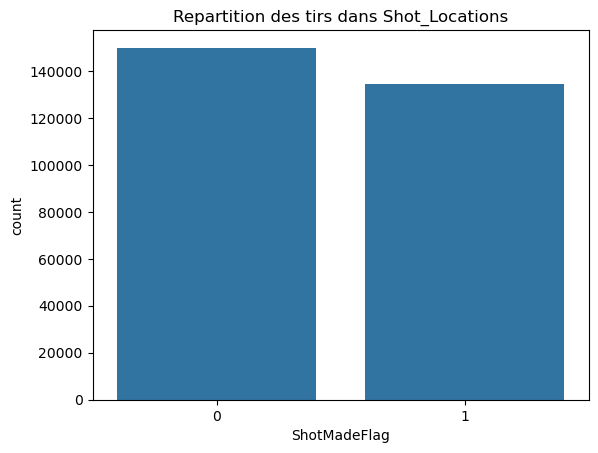

In [135]:
# Vérification de la répartition des tirs pour estimer si le jeu de données est équilibré
plt.title('Repartition des tirs dans Shot_Locations')
sns.countplot(x=df_06['ShotMadeFlag'])
print(df_06['ShotMadeFlag'].value_counts(normalize=1))

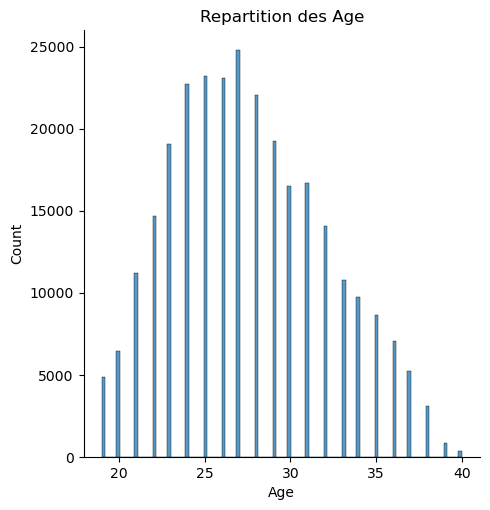

In [136]:
# Vérification de la répartition des tirs pour estimer si le jeu de données est équilibré
sns.displot(x=df_06['Age'])
plt.title('Repartition des Age')
plt.show();

In [33]:
# Calcul de la fréquence de chaque point
freq = df_06.groupby(['XLocation', 'YLocation']).size().reset_index(name='Frequency')
shot_locations_gb = pd.merge(df_06, freq, on=['XLocation', 'YLocation'])

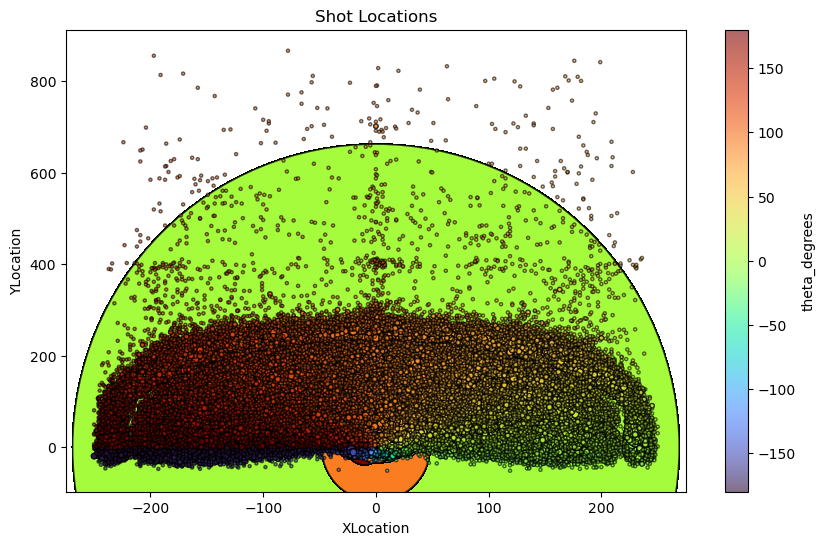

In [34]:
# Tracer le diagramme de dispersion avec la taille des points en fonction de leur fréquence
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    shot_locations_gb['XLocation'],
    shot_locations_gb['YLocation'],
    alpha=0.6,
    c=shot_locations_gb['theta_degrees'],
    cmap=plt.get_cmap("turbo"),
    s=shot_locations_gb['Frequency'] *5,  
    edgecolor='k')

# Ajouter une barre de couleur
colorbar = plt.colorbar(scatter)
colorbar.set_label('theta_degrees')

# Ajouter des étiquettes et un titre
plt.xlabel('XLocation')
plt.ylabel('YLocation')
plt.title('Shot Locations')

plt.show()

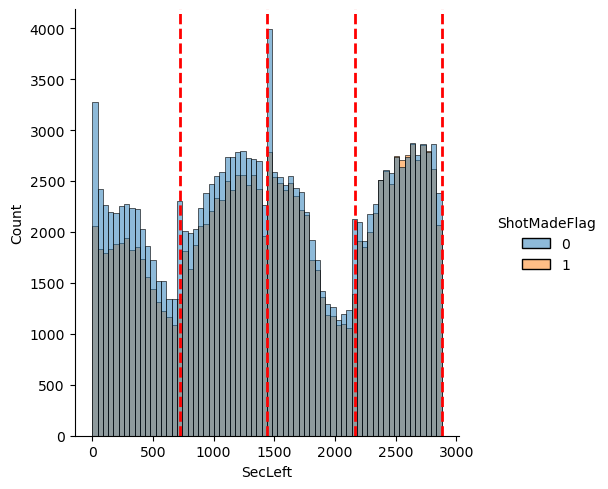

In [137]:
sns.displot(x = 'SecLeft', data = df_06, hue='ShotMadeFlag')
# Ajout des barres verticales rouges
for x in [720, 1440, 2160, 2880]:
    plt.axvline(x=x, color='red', linestyle='--', linewidth=2)    
plt.show();

# 4. Models
___
___

## LightGBM
___
___

In [3]:
df_06 = pd.read_csv('df_06.csv')
df_06.head()

,PlayerName,ShotType,ShotZoneBasic,ShotZoneArea,ShotDistance,XLocation,YLocation,ShotMadeFlag,AwayTeam,LastShotMadeFlag,NUM_REST_DAYS,height,weight,Pos,Age,Tm,FG%,2P%,3P%,FT%,PTS,theta_degrees,HomeGame,vsTeam,FOULER,REBOUNDER,TURNOVER,SCORE_MARGIN,SecLeft,ActionTypeRange,PlayerTmScore
0,Allen Iverson,2PT Field Goal,Mid-Range,Left Side Center(LC),19,-107,167,0,PHI,0.0,165.0,183.0,74.0,SG,24.0,PHI,0.421,0.435,0.341,0.713,1989.0,123.0,0,NYK,Empty,Empty,Empty,0.0,2828,Jump Shot,0
1,Allen Iverson,2PT Field Goal,Mid-Range,Left Side Center(LC),21,-115,177,1,PHI,0.0,165.0,183.0,74.0,SG,24.0,PHI,0.421,0.435,0.341,0.713,1989.0,123.0,0,NYK,Empty,Empty,Empty,-2.0,2637,Jump Shot,7
2,Allen Iverson,2PT Field Goal,Mid-Range,Right Side(R),16,165,13,0,PHI,1.0,165.0,183.0,74.0,SG,24.0,PHI,0.421,0.435,0.341,0.713,1989.0,5.0,0,NYK,Empty,Empty,Empty,0.0,2603,Jump Shot,9
3,Allen Iverson,2PT Field Goal,In The Paint (Non-RA),Center(C),14,-65,127,0,PHI,0.0,165.0,183.0,74.0,SG,24.0,PHI,0.421,0.435,0.341,0.713,1989.0,117.0,0,NYK,Empty,Empty,Empty,-2.0,2517,Jump Shot,11
4,Allen Iverson,3PT Field Goal,Right Corner 3,Right Side(R),23,235,40,0,PHI,0.0,165.0,183.0,74.0,SG,24.0,PHI,0.421,0.435,0.341,0.713,1989.0,10.0,0,NYK,Empty,Empty,Empty,-5.0,2338,Jump Shot,15


In [4]:
df_07 = df_06.reset_index(drop=True)
print(df_07.shape)
df_07.head()

(284115, 31)


,PlayerName,ShotType,ShotZoneBasic,ShotZoneArea,ShotDistance,XLocation,YLocation,ShotMadeFlag,AwayTeam,LastShotMadeFlag,NUM_REST_DAYS,height,weight,Pos,Age,Tm,FG%,2P%,3P%,FT%,PTS,theta_degrees,HomeGame,vsTeam,FOULER,REBOUNDER,TURNOVER,SCORE_MARGIN,SecLeft,ActionTypeRange,PlayerTmScore
0,Allen Iverson,2PT Field Goal,Mid-Range,Left Side Center(LC),19,-107,167,0,PHI,0.0,165.0,183.0,74.0,SG,24.0,PHI,0.421,0.435,0.341,0.713,1989.0,123.0,0,NYK,Empty,Empty,Empty,0.0,2828,Jump Shot,0
1,Allen Iverson,2PT Field Goal,Mid-Range,Left Side Center(LC),21,-115,177,1,PHI,0.0,165.0,183.0,74.0,SG,24.0,PHI,0.421,0.435,0.341,0.713,1989.0,123.0,0,NYK,Empty,Empty,Empty,-2.0,2637,Jump Shot,7
2,Allen Iverson,2PT Field Goal,Mid-Range,Right Side(R),16,165,13,0,PHI,1.0,165.0,183.0,74.0,SG,24.0,PHI,0.421,0.435,0.341,0.713,1989.0,5.0,0,NYK,Empty,Empty,Empty,0.0,2603,Jump Shot,9
3,Allen Iverson,2PT Field Goal,In The Paint (Non-RA),Center(C),14,-65,127,0,PHI,0.0,165.0,183.0,74.0,SG,24.0,PHI,0.421,0.435,0.341,0.713,1989.0,117.0,0,NYK,Empty,Empty,Empty,-2.0,2517,Jump Shot,11
4,Allen Iverson,3PT Field Goal,Right Corner 3,Right Side(R),23,235,40,0,PHI,0.0,165.0,183.0,74.0,SG,24.0,PHI,0.421,0.435,0.341,0.713,1989.0,10.0,0,NYK,Empty,Empty,Empty,-5.0,2338,Jump Shot,15


In [5]:
# Liste des colonnes à convertir en catégorie
cat_columns = [
    'PlayerName', 'ShotType', 'ShotZoneBasic', 'ShotZoneArea', 'Pos', 'Tm','FOULER', 'REBOUNDER',
    'TURNOVER', 'ActionTypeRange','AwayTeam','vsTeam'
]

# Convertir les colonnes en type catégorie
for col in cat_columns:
    if col in df_07.columns:
        df_07[col] = df_07[col].astype('category')

In [6]:
# Insérez votre code ici
X = df_07.drop('ShotMadeFlag', axis=1)
y = df_07['ShotMadeFlag']

In [7]:

def objective(trial):
    param = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 5, 20),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
    }

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    accuracies = []

    for train_index, test_index in skf.split(X, y):
        X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
        
        gbm = lgb.LGBMClassifier(**param)
        gbm.fit(X_train_fold, y_train_fold, eval_set=[(X_test_fold, y_test_fold)], eval_metric='binary_logloss')
        
        preds = gbm.predict(X_test_fold)
        accuracy = accuracy_score(y_test_fold, preds)
        accuracies.append(accuracy)
    
    return np.mean(accuracies)

# Utilisation d'Optuna pour l'optimisation des hyperparamètres
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Affichage des meilleurs hyperparamètres trouvés
print(f'Best hyperparameters: {study.best_params}')

# Évaluation finale avec k-fold cross-validation
best_params = study.best_params


[I 2024-10-11 15:31:16,876] A new study created in memory with name: no-name-c0538a17-eba2-400c-bd39-41b3d9a89af1
Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  File "c:\Users\weiss\anaconda3\envs\tensorflow_env\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")
[I 2024-10-11 15:31:44,546] Trial 0 finished with value: 0.6621403304999737 and parameters: {'num_leaves': 129, 'max_depth': 6, 'learning_rate': 0.08000990480303305, 'n_estimators': 717, 'subsample': 0.6898811654035764, 'colsample_bytree': 0.5212953189161575}. Best is trial 0 with value: 0.6621403304999737.
[I 2024-10-11 15:32:16,704] Trial 1 finished with value: 0.6599827534625063 and parameters: {'num_leaves': 104, 'm

Best hyperparameters: {'num_leaves': 66, 'max_depth': 19, 'learning_rate': 0.031102519605590136, 'n_estimators': 862, 'subsample': 0.503205519396856, 'colsample_bytree': 0.556366704644408}


In [8]:
accuracies = []
roc_aucs = []
feature_importances = pd.DataFrame()
combined_conf_matrix = np.zeros((2, 2))

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Accumulateur pour les vraies valeurs et les prédictions
all_y_true = []
all_y_pred = []

best_params = {'num_leaves': 66, 
               'max_depth': 19, 
               'learning_rate': 0.031102519605590136, 
               'n_estimators': 862, 
               'subsample': 0.503205519396856, 
               'colsample_bytree': 0.556366704644408}

# Boucle de validation croisée
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train_fold = X.iloc[train_index].copy()
    X_test_fold = X.iloc[test_index].copy()
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    
    best_gbm = lgb.LGBMClassifier(**best_params)
    best_gbm.fit(X_train_fold, y_train_fold)
    
    y_pred_proba = best_gbm.predict_proba(X_test_fold)[:, 1]
    y_pred = best_gbm.predict(X_test_fold)  
    
    accuracies.append(accuracy_score(y_test_fold, y_pred))
    roc_aucs.append(roc_auc_score(y_test_fold, y_pred))

    # Ajouter les importances des features pour cette fold
    fold_importances = pd.DataFrame()
    fold_importances['feature'] = X.columns
    fold_importances['importance'] = best_gbm.feature_importances_
    fold_importances['fold'] = fold + 1
    feature_importances = pd.concat([feature_importances, fold_importances], axis=0)
    
    # Ajouter la matrice de confusion de ce fold à la matrice combinée
    conf_matrix = confusion_matrix(y_test_fold, y_pred)
    combined_conf_matrix += conf_matrix
    
    # Accumuler les vraies valeurs et les prédictions
    all_y_true.extend(y_test_fold)
    all_y_pred.extend(y_pred)
    
# Moyenne des résultats de la validation croisée
final_accuracy = np.mean(accuracies)
final_roc_auc = np.mean(roc_aucs)

print(f'Final Accuracy: {final_accuracy}')
print(f'Final ROC AUC: {final_roc_auc}')

# Moyenne des importances des features
mean_feature_importances = feature_importances.groupby('feature')['importance'].mean().sort_values(ascending=False)

Final Accuracy: 0.6642908681343822
Final ROC AUC: 0.6575981735375427


Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.78      0.71    149875
           1       0.68      0.54      0.60    134240

    accuracy                           0.66    284115
   macro avg       0.67      0.66      0.66    284115
weighted avg       0.67      0.66      0.66    284115



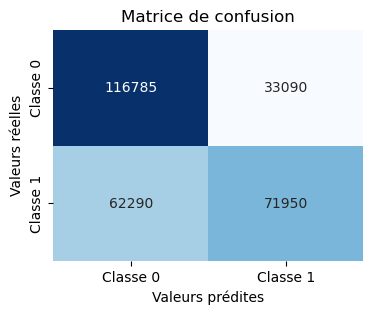

In [9]:
# Rapport de classification et matrice de confusion combinés
report = classification_report(all_y_true, all_y_pred)
print("Classification Report:")
print(report)

# Matrice de confusion combinée
combined_conf_matrix = confusion_matrix(all_y_true, all_y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(combined_conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False,
            xticklabels=['Classe 0', 'Classe 1'],
            yticklabels=['Classe 0', 'Classe 1'])
plt.xlabel('Valeurs prédites')
plt.ylabel('Valeurs réelles')
plt.title('Matrice de confusion')
plt.show()

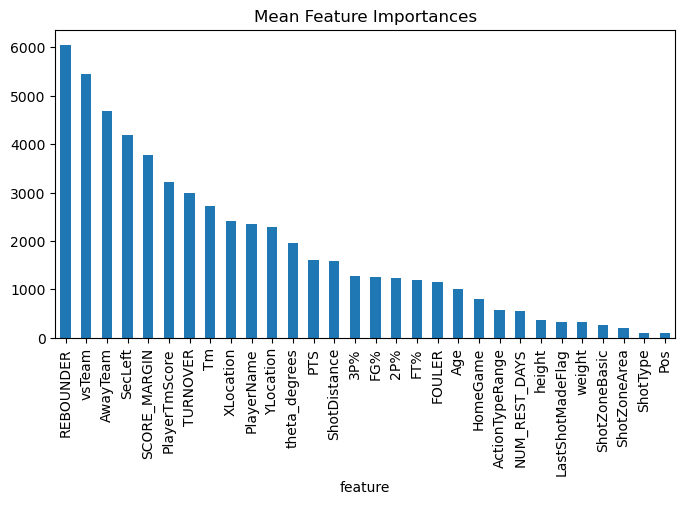

In [10]:
plt.figure(figsize=(8, 4))
mean_feature_importances.plot(kind='bar')
plt.title('Mean Feature Importances')
plt.show()

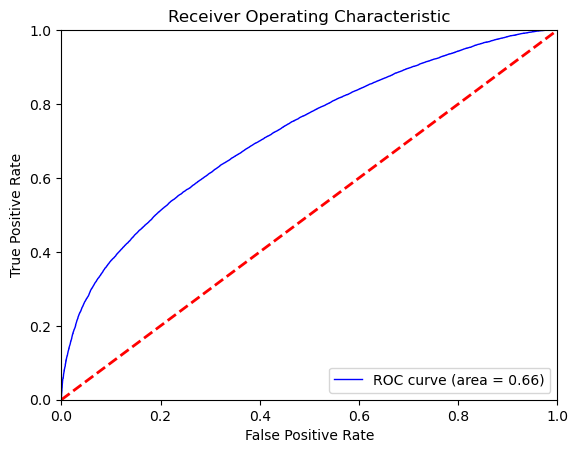

In [11]:
fpr, tpr, _ = roc_curve(y_test_fold, y_pred_proba)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=1, label=f'ROC curve (area = {final_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [12]:
# SHAP values
explainer = shap.TreeExplainer(best_gbm, feature_perturbation="tree_path_dependent")
shap_values = explainer.shap_values(X)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [13]:
# Visualiser les SHAP values pour une instance individuelle
shap.initjs()

# Extraire les valeurs de base et les valeurs SHAP pour une instance individuelle
base_value = explainer.expected_value[0]
shap_value = shap_values[0][1]

In [14]:
# Extraire les caractéristiques pour une instance individuelle
features = X.iloc[1, :]

# Utiliser shap.force_plot avec les arguments corrects
shap.force_plot(base_value, shap_value, features)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


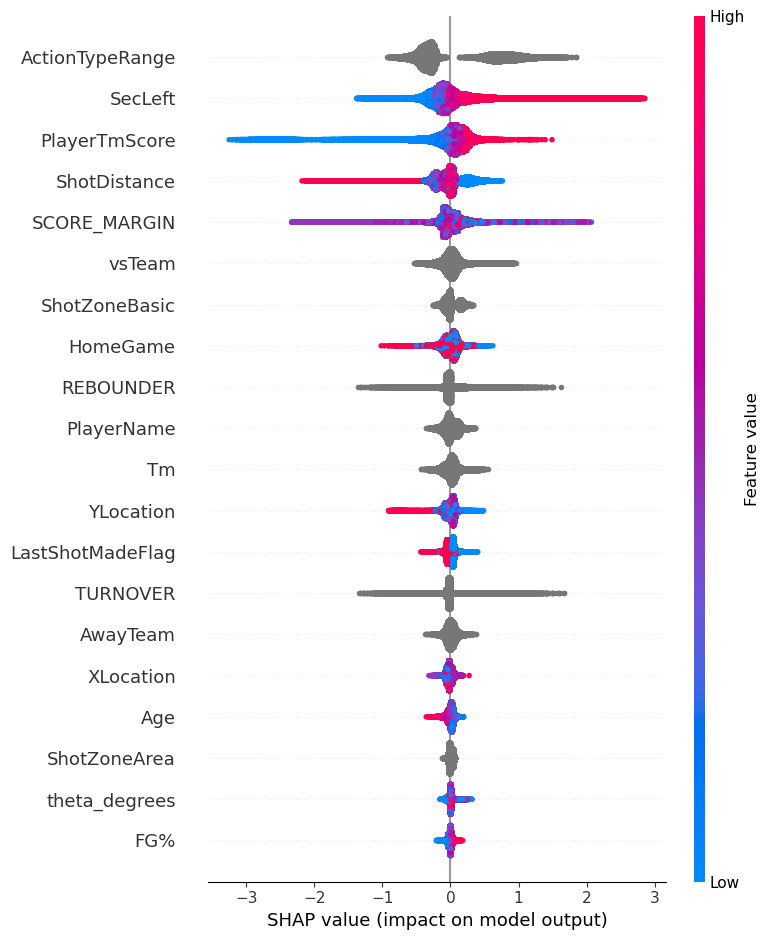

In [15]:
# Visualiser les SHAP values pour toutes les instances
shap_values = shap_values[1]
shap.summary_plot(shap_values, X)

In [16]:
# Entrainement de 5 modèles par cross-validation, prédiction sur l'oof et évaluation de l'AUC

skf = StratifiedKFold(n_splits=5, random_state=42, shuffle = True)

oof_prediction = pd.DataFrame()
list_auc = []

for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    print(f"Fold {i+1}:")
    
    X_train, X_test, y_train, y_test = X.iloc[train_index].copy(), X.iloc[test_index].copy(), y.iloc[train_index].copy(), y.iloc[test_index].copy()
    
    lgbm_classifier = lgb.LGBMClassifier(**best_params, verbose=-1)
    
    lgbm_classifier.fit(X_train, y_train)
    y_pred_proba_lgbm = lgbm_classifier.predict_proba(X_test)[:, 1]
    y_pred_int = lgbm_classifier.predict(X_test)  # Assurez-vous d'utiliser lgbm_classifier ici
    
    auc = roc_auc_score(y_test, y_pred_proba_lgbm)
    list_auc.append(auc)
    
    print(f"AUC : {auc:.2f}")
    print("\n")
    
    # Assurez-vous que les longueurs correspondent
    assert len(X_test) == len(y_pred_proba_lgbm)
    assert len(X_test) == len(y_pred_int)
    
    X_test['proba_pred'] = y_pred_proba_lgbm
    X_test['proba_int'] = y_pred_int
    oof_prediction = pd.concat([oof_prediction, X_test])
    
print(f"AUC moyenne : {np.mean(list_auc):.3f}")

Fold 1:
AUC : 0.73


Fold 2:
AUC : 0.72


Fold 3:
AUC : 0.72


Fold 4:
AUC : 0.72


Fold 5:
AUC : 0.72


AUC moyenne : 0.722


In [17]:
oof_prediction.head()

,PlayerName,ShotType,ShotZoneBasic,ShotZoneArea,ShotDistance,XLocation,YLocation,AwayTeam,LastShotMadeFlag,NUM_REST_DAYS,height,weight,Pos,Age,Tm,FG%,2P%,3P%,FT%,PTS,theta_degrees,HomeGame,vsTeam,FOULER,REBOUNDER,TURNOVER,SCORE_MARGIN,SecLeft,ActionTypeRange,PlayerTmScore,proba_pred,proba_int
10,Allen Iverson,2PT Field Goal,Restricted Area,Center(C),0,0,0,PHI,0.0,165.0,183.0,74.0,SG,24.0,PHI,0.421,0.435,0.341,0.713,1989.0,0.0,0,NYK,Empty,Theo Ratliff,Empty,-12.0,1487,Driving Layup Shot,39,0.869090,1
11,Allen Iverson,2PT Field Goal,Restricted Area,Center(C),0,0,0,PHI,1.0,165.0,183.0,74.0,SG,24.0,PHI,0.421,0.435,0.341,0.713,1989.0,0.0,0,NYK,Empty,Tyrone Hill,Empty,-15.0,1236,Layup Shot,43,0.303489,0
16,Vince Carter,2PT Field Goal,Mid-Range,Left Side(L),18,-176,42,DET,0.0,184.0,198.0,99.0,SF,23.0,TOR,0.465,0.475,0.403,0.791,2107.0,167.0,1,DET,Empty,Antonio Davis,Empty,0.0,2858,Jump Shot,0,0.016012,0
17,Vince Carter,3PT Field Goal,Above the Break 3,Right Side Center(RC),25,195,158,DET,0.0,184.0,198.0,99.0,SF,23.0,TOR,0.465,0.475,0.403,0.791,2107.0,39.0,1,DET,Empty,Empty,Empty,-2.0,2819,Jump Shot,2,0.065836,0
19,Vince Carter,2PT Field Goal,Mid-Range,Right Side(R),9,94,26,DET,1.0,184.0,198.0,99.0,SF,23.0,TOR,0.465,0.475,0.403,0.791,2107.0,15.0,1,DET,Mikki Moore,Empty,Empty,-4.0,2133,OtherShot,27,0.512511,1


## XGBoost
___
___

In [21]:
def objective(trial):
    param = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'verbosity': 0,
        'booster': trial.suggest_categorical('booster', ['gbtree', 'dart']),
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0),
        'max_depth': trial.suggest_int('max_depth', 5, 20),
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'gamma': trial.suggest_float('gamma', 0.0, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
    }

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    accuracies = []

    for train_index, test_index in skf.split(X, y):
        X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
        
        dtrain = xgb.DMatrix(X_train_fold, label=y_train_fold, enable_categorical=True)
        dval = xgb.DMatrix(X_test_fold, label=y_test_fold, enable_categorical=True)
        
        bst = xgb.train(param, dtrain, evals=[(dval, 'eval')], verbose_eval=False)
        
        preds = bst.predict(dval)
        preds_binary = np.where(preds > 0.5, 1, 0)
        
        accuracy = accuracy_score(y_test_fold, preds_binary)
        accuracies.append(accuracy)
      
        return np.mean(accuracies)

In [22]:
# Utilisation d'Optuna pour l'optimisation des hyperparamètres
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Affichage des meilleurs hyperparamètres trouvés
print(f'Best hyperparameters: {study.best_params}')


[I 2024-10-11 17:34:28,968] A new study created in memory with name: no-name-179f160f-fb33-45c5-a6a7-e706f1bcafd2
[I 2024-10-11 17:34:29,744] Trial 0 finished with value: 0.6390722066768738 and parameters: {'booster': 'dart', 'lambda': 0.7943043173745732, 'alpha': 0.20042866837401135, 'max_depth': 7, 'eta': 0.0952471740759606, 'gamma': 0.6051287946894335, 'subsample': 0.5897824445611946, 'colsample_bytree': 0.5592268084424232}. Best is trial 0 with value: 0.6390722066768738.
[I 2024-10-11 17:34:30,613] Trial 1 finished with value: 0.6472731112401668 and parameters: {'booster': 'dart', 'lambda': 0.6068485947175692, 'alpha': 0.6334429529280914, 'max_depth': 7, 'eta': 0.24367068081915846, 'gamma': 0.31264751167926375, 'subsample': 0.8488390794293184, 'colsample_bytree': 0.868892248707654}. Best is trial 1 with value: 0.6472731112401668.
[I 2024-10-11 17:34:31,405] Trial 2 finished with value: 0.6450556992767014 and parameters: {'booster': 'dart', 'lambda': 0.632414849528957, 'alpha': 0.66

Best hyperparameters: {'booster': 'gbtree', 'lambda': 0.436869564933095, 'alpha': 0.16293806530991928, 'max_depth': 9, 'eta': 0.1557840369964976, 'gamma': 0.4973274928149489, 'subsample': 0.9118784583410455, 'colsample_bytree': 0.7152008137833128}


In [23]:
# Initialisation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Supposons que study.best_params contient les meilleurs paramètres
best_params = study.best_params

accuracies = []
roc_aucs = []

# Liste pour sauvegarder les feature importances
feature_importances = []

# Accumulateurs pour les vraies valeurs et les prédictions
all_y_true = []
all_y_pred = []

# Boucle de validation croisée
for train_index, test_index in skf.split(X, y):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    
    # Convertir les données en format DMatrix pour XGBoost
    dtrain = xgb.DMatrix(X_train_fold, label=y_train_fold, enable_categorical=True)
    dval = xgb.DMatrix(X_test_fold, label=y_test_fold, enable_categorical=True)
    
    # Entraîner le modèle XGBoost
    bst = xgb.train(best_params, dtrain, evals=[(dval, 'eval')], verbose_eval=False)
    
    # Prédictions sur les données de validation
    preds = bst.predict(dval)
    preds_binary = np.where(preds > 0.5, 1, 0)
    
    # Calcul des métriques de performance
    accuracies.append(accuracy_score(y_test_fold, preds_binary))
    roc_aucs.append(roc_auc_score(y_test_fold, preds))
    
    # Récupérer les feature importances
    fold_importance = bst.get_score(importance_type='weight')  # Vous pouvez utiliser 'weight', 'gain' ou 'cover'
    feature_importances.append(fold_importance)
    
    # Accumuler les vraies valeurs et les prédictions
    all_y_true.extend(y_test_fold)
    all_y_pred.extend(preds_binary)

# Moyenne des résultats de la validation croisée
final_accuracy = np.mean(accuracies)
final_roc_auc = np.mean(roc_aucs)

print(f'Final Accuracy: {final_accuracy}')
print(f'Final ROC AUC: {final_roc_auc}')

Final Accuracy: 0.642046354469141
Final ROC AUC: 0.6802862845826032


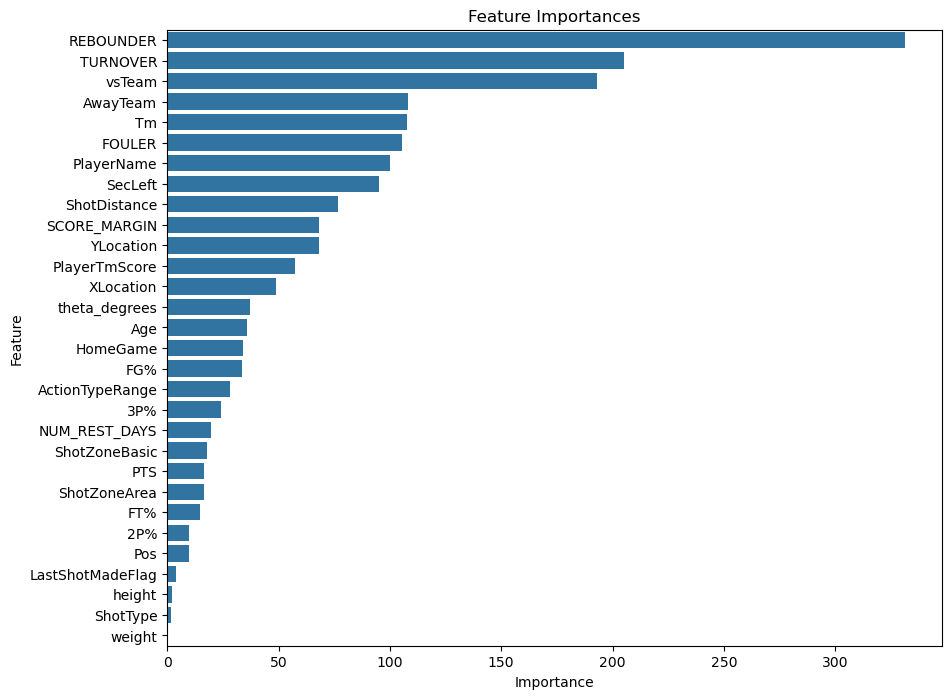

In [24]:
# Agréger les feature importances de toutes les folds
all_feature_importances = {}
for fold_importance in feature_importances:
    for feature, importance in fold_importance.items():
        if feature in all_feature_importances:
            all_feature_importances[feature] += importance
        else:
            all_feature_importances[feature] = importance

# Normalisation par le nombre de folds
num_folds = skf.get_n_splits()
for feature in all_feature_importances:
    all_feature_importances[feature] /= num_folds

# Convertir en DataFrame pour l'affichage et le tri
feature_importances_df = pd.DataFrame(list(all_feature_importances.items()), columns=['feature', 'importance'])
feature_importances_df = feature_importances_df.sort_values(by='importance', ascending=False)

# Plot des feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importances_df)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

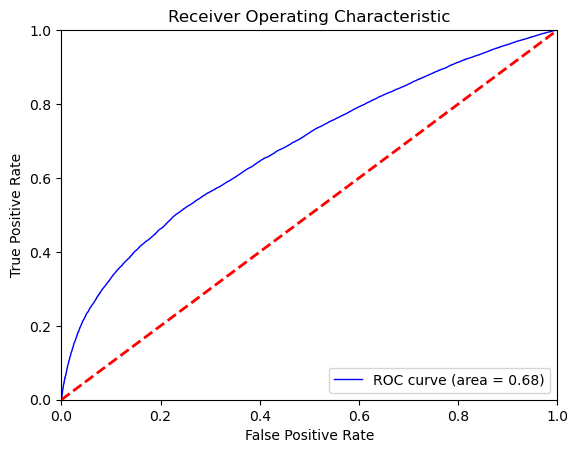

In [25]:
fpr, tpr, _ = roc_curve(y_test_fold, preds)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=1, label=f'ROC curve (area = {final_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.81      0.70    149875
           1       0.68      0.46      0.55    134240

    accuracy                           0.64    284115
   macro avg       0.65      0.63      0.63    284115
weighted avg       0.65      0.64      0.63    284115



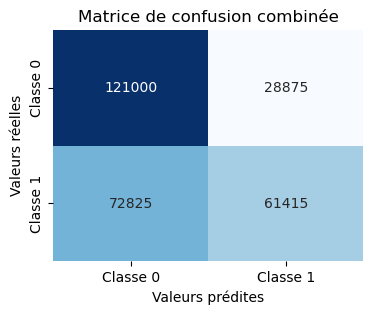

In [26]:
# Rapport de classification combiné
report = classification_report(all_y_true, all_y_pred)
print("Classification Report:")
print(report)

# Matrice de confusion combinée
combined_conf_matrix = confusion_matrix(all_y_true, all_y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(combined_conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False,
            xticklabels=['Classe 0', 'Classe 1'],
            yticklabels=['Classe 0', 'Classe 1'])
plt.xlabel('Valeurs prédites')
plt.ylabel('Valeurs réelles')
plt.title('Matrice de confusion combinée')
plt.show()

# Deep Neural Network

In [2]:
df_06 = pd.read_csv('df_06.csv')
df_06.head()

,PlayerName,ShotType,ShotZoneBasic,ShotZoneArea,ShotDistance,XLocation,YLocation,ShotMadeFlag,AwayTeam,LastShotMadeFlag,NUM_REST_DAYS,height,weight,Pos,Age,Tm,FG%,2P%,3P%,FT%,PTS,theta_degrees,HomeGame,vsTeam,FOULER,REBOUNDER,TURNOVER,SCORE_MARGIN,SecLeft,ActionTypeRange,PlayerTmScore
0,Allen Iverson,2PT Field Goal,Mid-Range,Left Side Center(LC),19,-107,167,0,PHI,0.0,165.0,183.0,74.0,SG,24.0,PHI,0.421,0.435,0.341,0.713,1989.0,123.0,0,NYK,Empty,Empty,Empty,0.0,2828,Jump Shot,0
1,Allen Iverson,2PT Field Goal,Mid-Range,Left Side Center(LC),21,-115,177,1,PHI,0.0,165.0,183.0,74.0,SG,24.0,PHI,0.421,0.435,0.341,0.713,1989.0,123.0,0,NYK,Empty,Empty,Empty,-2.0,2637,Jump Shot,7
2,Allen Iverson,2PT Field Goal,Mid-Range,Right Side(R),16,165,13,0,PHI,1.0,165.0,183.0,74.0,SG,24.0,PHI,0.421,0.435,0.341,0.713,1989.0,5.0,0,NYK,Empty,Empty,Empty,0.0,2603,Jump Shot,9
3,Allen Iverson,2PT Field Goal,In The Paint (Non-RA),Center(C),14,-65,127,0,PHI,0.0,165.0,183.0,74.0,SG,24.0,PHI,0.421,0.435,0.341,0.713,1989.0,117.0,0,NYK,Empty,Empty,Empty,-2.0,2517,Jump Shot,11
4,Allen Iverson,3PT Field Goal,Right Corner 3,Right Side(R),23,235,40,0,PHI,0.0,165.0,183.0,74.0,SG,24.0,PHI,0.421,0.435,0.341,0.713,1989.0,10.0,0,NYK,Empty,Empty,Empty,-5.0,2338,Jump Shot,15


In [3]:
df_07 = df_06.reset_index(drop=True)
print(df_07.shape)
df_07.head()

(284115, 31)


,PlayerName,ShotType,ShotZoneBasic,ShotZoneArea,ShotDistance,XLocation,YLocation,ShotMadeFlag,AwayTeam,LastShotMadeFlag,NUM_REST_DAYS,height,weight,Pos,Age,Tm,FG%,2P%,3P%,FT%,PTS,theta_degrees,HomeGame,vsTeam,FOULER,REBOUNDER,TURNOVER,SCORE_MARGIN,SecLeft,ActionTypeRange,PlayerTmScore
0,Allen Iverson,2PT Field Goal,Mid-Range,Left Side Center(LC),19,-107,167,0,PHI,0.0,165.0,183.0,74.0,SG,24.0,PHI,0.421,0.435,0.341,0.713,1989.0,123.0,0,NYK,Empty,Empty,Empty,0.0,2828,Jump Shot,0
1,Allen Iverson,2PT Field Goal,Mid-Range,Left Side Center(LC),21,-115,177,1,PHI,0.0,165.0,183.0,74.0,SG,24.0,PHI,0.421,0.435,0.341,0.713,1989.0,123.0,0,NYK,Empty,Empty,Empty,-2.0,2637,Jump Shot,7
2,Allen Iverson,2PT Field Goal,Mid-Range,Right Side(R),16,165,13,0,PHI,1.0,165.0,183.0,74.0,SG,24.0,PHI,0.421,0.435,0.341,0.713,1989.0,5.0,0,NYK,Empty,Empty,Empty,0.0,2603,Jump Shot,9
3,Allen Iverson,2PT Field Goal,In The Paint (Non-RA),Center(C),14,-65,127,0,PHI,0.0,165.0,183.0,74.0,SG,24.0,PHI,0.421,0.435,0.341,0.713,1989.0,117.0,0,NYK,Empty,Empty,Empty,-2.0,2517,Jump Shot,11
4,Allen Iverson,3PT Field Goal,Right Corner 3,Right Side(R),23,235,40,0,PHI,0.0,165.0,183.0,74.0,SG,24.0,PHI,0.421,0.435,0.341,0.713,1989.0,10.0,0,NYK,Empty,Empty,Empty,-5.0,2338,Jump Shot,15


In [4]:
# Liste des colonnes à convertir en catégorie
cat_columns = [
    'PlayerName', 'ShotType', 'ShotZoneBasic', 'ShotZoneArea', 'Pos', 'Tm','FOULER', 'REBOUNDER',
    'TURNOVER', 'ActionTypeRange','AwayTeam','vsTeam'
]

# Convertir les colonnes en type catégorie
for col in cat_columns:
    if col in df_07.columns:
        df_07[col] = df_07[col].astype('category')

In [5]:
# Encodage des variables catégorielles
label_encoders = {}
for column in ['PlayerName', 'ShotType', 'ShotZoneBasic','AwayTeam','FOULER','REBOUNDER',
               'TURNOVER','ActionTypeRange', 'ShotZoneArea', 'Pos', 'Tm','vsTeam']:
    le = LabelEncoder()
    df_07[column] = le.fit_transform(df_07[column])
    label_encoders[column] = le

In [6]:
# Séparation des caractéristiques (X) et de la cible (y)
X = df_07.drop(columns=['ShotMadeFlag'])
y = df_07['ShotMadeFlag']

In [7]:
X.head()

,PlayerName,ShotType,ShotZoneBasic,ShotZoneArea,ShotDistance,XLocation,YLocation,AwayTeam,LastShotMadeFlag,NUM_REST_DAYS,height,weight,Pos,Age,Tm,FG%,2P%,3P%,FT%,PTS,theta_degrees,HomeGame,vsTeam,FOULER,REBOUNDER,TURNOVER,SCORE_MARGIN,SecLeft,ActionTypeRange,PlayerTmScore
0,0,0,4,2,19,-107,167,26,0.0,165.0,183.0,74.0,6,24.0,20,0.421,0.435,0.341,0.713,1989.0,123.0,0,23,353,332,380,0.0,2828,1,0
1,0,0,4,2,21,-115,177,26,0.0,165.0,183.0,74.0,6,24.0,20,0.421,0.435,0.341,0.713,1989.0,123.0,0,23,353,332,380,-2.0,2637,1,7
2,0,0,4,5,16,165,13,26,1.0,165.0,183.0,74.0,6,24.0,20,0.421,0.435,0.341,0.713,1989.0,5.0,0,23,353,332,380,0.0,2603,1,9
3,0,0,2,1,14,-65,127,26,0.0,165.0,183.0,74.0,6,24.0,20,0.421,0.435,0.341,0.713,1989.0,117.0,0,23,353,332,380,-2.0,2517,1,11
4,0,1,6,5,23,235,40,26,0.0,165.0,183.0,74.0,6,24.0,20,0.421,0.435,0.341,0.713,1989.0,10.0,0,23,353,332,380,-5.0,2338,1,15


In [8]:
X = X.astype(np.float32)
y = y.astype(np.int32)

In [9]:
# Normalisation des caractéristiques numériques
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [10]:
# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Deep Learning Model: Test 1
___

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Création du modèle de deep learning
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))


In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1984      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,097
Trainable params: 4,097
Non-trainable params: 0
_________________________________________________________________


In [38]:
# Compilation du modèle
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [39]:
# Entraînement du modèle
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
5683/5683 [==============================] - 9s 1ms/step - loss: 0.6731 - accuracy: 0.5935 - val_loss: 0.6508 - val_accuracy: 0.6288
Epoch 2/20
5683/5683 [==============================] - 8s 1ms/step - loss: 0.6536 - accuracy: 0.6233 - val_loss: 0.6395 - val_accuracy: 0.6419
Epoch 3/20
5683/5683 [==============================] - 7s 1ms/step - loss: 0.6470 - accuracy: 0.6327 - val_loss: 0.6363 - val_accuracy: 0.6428
Epoch 4/20
5683/5683 [==============================] - 7s 1ms/step - loss: 0.6438 - accuracy: 0.6366 - val_loss: 0.6315 - val_accuracy: 0.6459
Epoch 5/20
5683/5683 [==============================] - 7s 1ms/step - loss: 0.6423 - accuracy: 0.6396 - val_loss: 0.6303 - val_accuracy: 0.6469
Epoch 6/20
5683/5683 [==============================] - 7s 1ms/step - loss: 0.6408 - accuracy: 0.6393 - val_loss: 0.6308 - val_accuracy: 0.6478
Epoch 7/20
5683/5683 [==============================] - 7s 1ms/step - loss: 0.6399 - accuracy: 0.6414 - val_loss: 0.6321 - val_accuracy:

In [40]:
# Évaluation du modèle
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

1776/1776 [==============================] - 2s 892us/step - loss: 0.6213 - accuracy: 0.6537
Test Accuracy: 0.65


1776/1776 [==============================] - 1s 727us/step


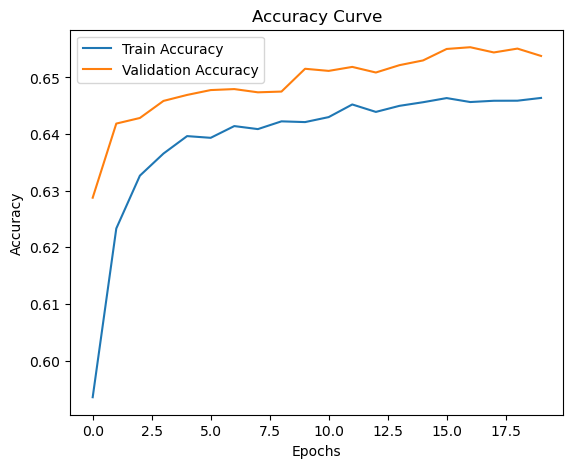

In [41]:
# Prédictions
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

# Tracer les courbes de perte et d'accuracy
plt.figure(figsize=(14,5))

# Courbe d'accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Deep Learning Model: Test 2
___

In [42]:
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               3968      
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 32)                2080      
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 14,337
Trainable params: 14,337
Non-trai

In [43]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  # ou essayer 0.0001
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [44]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
5683/5683 [==============================] - 10s 2ms/step - loss: 0.6641 - accuracy: 0.6065 - val_loss: 0.6493 - val_accuracy: 0.6368
Epoch 2/50
5683/5683 [==============================] - 9s 2ms/step - loss: 0.6480 - accuracy: 0.6311 - val_loss: 0.6413 - val_accuracy: 0.6437
Epoch 3/50
5683/5683 [==============================] - 9s 2ms/step - loss: 0.6430 - accuracy: 0.6353 - val_loss: 0.6369 - val_accuracy: 0.6461
Epoch 4/50
5683/5683 [==============================] - 9s 2ms/step - loss: 0.6403 - accuracy: 0.6379 - val_loss: 0.6316 - val_accuracy: 0.6465
Epoch 5/50
5683/5683 [==============================] - 9s 2ms/step - loss: 0.6388 - accuracy: 0.6402 - val_loss: 0.6354 - val_accuracy: 0.6474
Epoch 6/50
5683/5683 [==============================] - 9s 2ms/step - loss: 0.6367 - accuracy: 0.6416 - val_loss: 0.6309 - val_accuracy: 0.6482
Epoch 7/50
5683/5683 [==============================] - 9s 2ms/step - loss: 0.6358 - accuracy: 0.6432 - val_loss: 0.6325 - val_accuracy

In [45]:
# Évaluation du modèle
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

1776/1776 [==============================] - 2s 1ms/step - loss: 0.6157 - accuracy: 0.6621
Test Accuracy: 0.66


1776/1776 [==============================] - 2s 876us/step


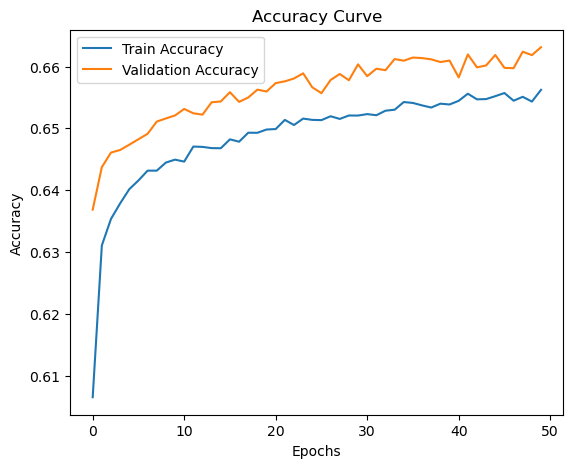

In [46]:
# Prédictions
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

# Tracer les courbes de perte et d'accuracy
plt.figure(figsize=(14,5))

# Courbe d'accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [47]:
# Générer le rapport de classification
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# Générer la matrice de confusion
print("Confusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))


Classification Report:

              precision    recall  f1-score   support

           0       0.65      0.79      0.71     29973
           1       0.69      0.52      0.59     26850

    accuracy                           0.66     56823
   macro avg       0.67      0.65      0.65     56823
weighted avg       0.67      0.66      0.66     56823

Confusion Matrix:

[[23655  6318]
 [12882 13968]]


### Deep Learning Model: Test 3
___

In [13]:
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU

model = Sequential()

# Première couche dense avec LeakyReLU
model.add(Dense(128, input_dim=X_train.shape[1]))
model.add(LeakyReLU(alpha=0.01))  # Ajout de LeakyReLU avec un alpha de 0.01
model.add(Dropout(0.5))

# Deuxième couche dense avec LeakyReLU
model.add(Dense(64))
model.add(LeakyReLU(alpha=0.01))  # Ajout de LeakyReLU avec un alpha de 0.01
model.add(Dropout(0.5))

# Troisième couche dense avec LeakyReLU
model.add(Dense(32))
model.add(LeakyReLU(alpha=0.01))  # Ajout de LeakyReLU avec un alpha de 0.01

# Couche de sortie avec la fonction d'activation sigmoïde
model.add(Dense(1, activation='sigmoid'))

# Résumé du modèle
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               3968      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128)               0         
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64)                0         
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 32)               

In [14]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  # ou essayer 0.0001
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [15]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
5683/5683 [==============================] - 13s 2ms/step - loss: 0.6631 - accuracy: 0.6088 - val_loss: 0.6427 - val_accuracy: 0.6386
Epoch 2/50
5683/5683 [==============================] - 11s 2ms/step - loss: 0.6471 - accuracy: 0.6322 - val_loss: 0.6413 - val_accuracy: 0.6428
Epoch 3/50
5683/5683 [==============================] - 11s 2ms/step - loss: 0.6424 - accuracy: 0.6360 - val_loss: 0.6346 - val_accuracy: 0.6444
Epoch 4/50
5683/5683 [==============================] - 10s 2ms/step - loss: 0.6399 - accuracy: 0.6394 - val_loss: 0.6339 - val_accuracy: 0.6492
Epoch 5/50
5683/5683 [==============================] - 12s 2ms/step - loss: 0.6388 - accuracy: 0.6405 - val_loss: 0.6372 - val_accuracy: 0.6478
Epoch 6/50
5683/5683 [==============================] - 13s 2ms/step - loss: 0.6366 - accuracy: 0.6414 - val_loss: 0.6322 - val_accuracy: 0.6496
Epoch 7/50
5683/5683 [==============================] - 10s 2ms/step - loss: 0.6355 - accuracy: 0.6423 - val_loss: 0.6308 - val_ac

In [16]:
# Évaluation du modèle
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.3f}")

1776/1776 [==============================] - 2s 1ms/step - loss: 0.6129 - accuracy: 0.6636
Test Accuracy: 0.664


1776/1776 [==============================] - 2s 867us/step


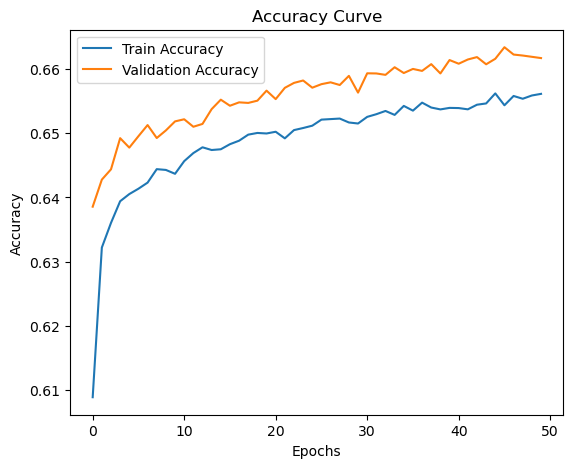

In [17]:
# Prédictions
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

# Tracer les courbes de perte et d'accuracy
plt.figure(figsize=(14,5))

# Courbe d'accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [18]:
# Générer le rapport de classification
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# Générer la matrice de confusion
print("Confusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))


Classification Report:

              precision    recall  f1-score   support

           0       0.65      0.78      0.71     29973
           1       0.68      0.54      0.60     26850

    accuracy                           0.66     56823
   macro avg       0.67      0.66      0.65     56823
weighted avg       0.67      0.66      0.66     56823

Confusion Matrix:

[[23339  6634]
 [12482 14368]]


### Deep Learning Model: Test 4
___

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

In [20]:
model = Sequential()

# Première couche dense avec régularisation L2
model.add(Dense(256, input_dim=X_train.shape[1], kernel_regularizer=l2(0.001)))
model.add(LeakyReLU(alpha=0.01))
model.add(Dropout(0.4))

# Deuxième couche dense avec régularisation L2
model.add(Dense(128, kernel_regularizer=l2(0.001)))
model.add(LeakyReLU(alpha=0.01))
model.add(Dropout(0.4))

# Troisième couche dense
model.add(Dense(64))
model.add(LeakyReLU(alpha=0.01))

# Quatrième couche dense
model.add(Dense(32))
model.add(LeakyReLU(alpha=0.01))

# Couche de sortie
model.add(Dense(1, activation='sigmoid'))

# Résumé du modèle
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 256)               7936      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 256)               0         
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_8 (Dense)             (None, 128)               32896     
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 128)               0         
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 64)               

In [21]:
# Compilation du modèle
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


In [22]:
# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [23]:
# Entraînement du modèle
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
5683/5683 [==============================] - 36s 6ms/step - loss: 0.8191 - accuracy: 0.5977 - val_loss: 0.7470 - val_accuracy: 0.6210
Epoch 2/100
5683/5683 [==============================] - 58s 10ms/step - loss: 0.7131 - accuracy: 0.6243 - val_loss: 0.6789 - val_accuracy: 0.6392
Epoch 3/100
5683/5683 [==============================] - 65s 11ms/step - loss: 0.6728 - accuracy: 0.6353 - val_loss: 0.6555 - val_accuracy: 0.6451
Epoch 4/100
5683/5683 [==============================] - 61s 11ms/step - loss: 0.6570 - accuracy: 0.6403 - val_loss: 0.6468 - val_accuracy: 0.6446
Epoch 5/100
5683/5683 [==============================] - 66s 12ms/step - loss: 0.6499 - accuracy: 0.6410 - val_loss: 0.6408 - val_accuracy: 0.6478
Epoch 6/100
5683/5683 [==============================] - 54s 9ms/step - loss: 0.6451 - accuracy: 0.6433 - val_loss: 0.6373 - val_accuracy: 0.6488
Epoch 7/100
5683/5683 [==============================] - 67s 12ms/step - loss: 0.6420 - accuracy: 0.6447 - val_loss: 0.6

In [ ]:
model.save("model_dl")

In [24]:
# Évaluation du modèle
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

1776/1776 [==============================] - 2s 1ms/step - loss: 0.6189 - accuracy: 0.6635
Test Accuracy: 0.6635


1776/1776 [==============================] - 2s 1ms/step


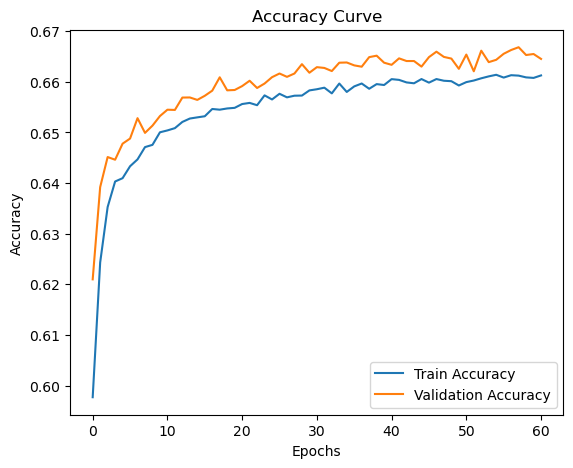

In [25]:
# Prédictions
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

# Tracer les courbes de perte et d'accuracy
plt.figure(figsize=(14,5))

# Courbe d'accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [26]:
# Générer le rapport de classification
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# Générer la matrice de confusion
print("Confusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))


Classification Report:

              precision    recall  f1-score   support

           0       0.65      0.77      0.71     29973
           1       0.68      0.54      0.60     26850

    accuracy                           0.66     56823
   macro avg       0.67      0.66      0.66     56823
weighted avg       0.67      0.66      0.66     56823

Confusion Matrix:

[[23074  6899]
 [12220 14630]]


In [ ]:
## Fin